# <b> <span style="color:white">Electricity Sector Data Integration & Augmentation</span></b>


# <b> <span style="color:white">GROUP 04</span></b>


| Name                   | SID       | Unikey   |
| ---------------------- | --------- | -------- |
| Putu Eka Udiyani Putri | 550067302 | pput0940 |
| Rengga Firmandika      | 550126632 | rfir0117 |
| Vincentius Ansel Suppa | 550206406 | vsup0468 |


## <b> <span style="color:orange">0. Import Required Libraries</span></b>


In [469]:
import pandas as pd
import numpy as np
import re
import requests
from pathlib import Path
import time
import os, glob
import json
import matplotlib.pyplot as plt

# For web crawling and scraping
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC

# For database processing with duckDB
import duckdb
from textwrap import dedent


## <b> <span style="color:orange">1. Data Acquisition</span></b>


### <b> <span style="color:pink">a. National Greenhouse and Energy Reporting (NGER)</span></b>


This dataset consists of 10 annual CSV files released by the Clean Energy Regulator, covering the years 2014 to 2024.  
The files contain information on electricity generation and emissions intensity from facilities that are connected to major electricity networks in Australia.


In [ ]:
BASE = "https://api.cer.gov.au/datahub-public/v1"
SCHEME = "NGER"
HEADERS = {"Accept": "application/json", "User-Agent": "Mozilla/5.0"}

OUT = Path("DATA1_ELECTRICITY"); OUT.mkdir(parents=True, exist_ok=True)


In [4]:
def get_json(path: str):
    url = BASE + path
    r = requests.get(url, headers=HEADERS, timeout=60)
    r.raise_for_status()
    return r.json()

In [5]:
schemes = get_json("/api/Schemes")
nger = next((s for s in schemes if (s.get("id") or "").upper() == SCHEME), None)
if not nger:
    raise SystemExit("Scheme NGER not found in /api/Schemes")

items = get_json(f"/api/Schemes/{SCHEME}/DatasetCatalogItems")
print(f"Total catalog items under {SCHEME}: {len(items)}")

PHRASE = "greenhouse and energy information by designated generation facility"
YEARS = [f"{y}-{str(y+1)[-2:]}" for y in range(2014, 2024)]
YEARS_SET = set(YEARS)

targets = []
for it in items:
    cid   = str(it.get("id") or "")
    title = str(it.get("displayName") or "").lower()
    if PHRASE in title:
        m = re.search(r"(20\d{2}[–-]\d{2})", title)
        fy = m.group(1).replace("–","-") if m else ""
        if fy in YEARS_SET:
            targets.append((fy, cid))

def fy_key(fy: str):
    a, b = fy.split("-")
    return (int(a), int(b))
targets.sort(key=lambda t: fy_key(t[0]))

print("\nTargets discovered:")
for fy, cid in targets:
    print(f"  {fy}  {cid}")


Total catalog items under NGER: 112

Targets discovered:
  2014-15  ID0075
  2015-16  ID0076
  2016-17  ID0077
  2017-18  ID0078
  2018-19  ID0079
  2019-20  ID0080
  2020-21  ID0081
  2021-22  ID0082
  2022-23  ID0083
  2023-24  ID0243


In [6]:
downloaded = 0
for fy, cid in targets:
    ok = False
    for ext in ["csv", "xlsx"]:
        url = f"{BASE}/api/Dataset/{SCHEME}/dataset/{cid}.{ext}"
        try:
            r = requests.get(url, headers=HEADERS, timeout=120)
            if r.ok and len(r.content) > 500:  # simple sanity check
                out = OUT / f"nger_{fy}.{ext}"
                out.write_bytes(r.content)
                print(f"[OK] {fy} -> {out.name} ({len(r.content)/1024:.1f} KB)")
                downloaded += 1
                ok = True
                break
            else:
                print(f"[TRY] {fy} no {ext.upper()} (status {r.status_code})")
        except Exception as e:
            print(f"[ERR] {fy} {ext.upper()}: {e}")
    if not ok:
        print(f"[WARN] {fy} ({cid}) no usable file")

print(f"\nDone. Downloaded {downloaded}/{len(targets)} files into {OUT.resolve()}")

[OK] 2014-15 -> nger_2014-15.csv (48.0 KB)
[OK] 2015-16 -> nger_2015-16.csv (48.5 KB)
[OK] 2016-17 -> nger_2016-17.csv (52.0 KB)
[OK] 2017-18 -> nger_2017-18.csv (55.2 KB)
[OK] 2018-19 -> nger_2018-19.csv (63.1 KB)
[OK] 2019-20 -> nger_2019-20.csv (66.6 KB)
[OK] 2020-21 -> nger_2020-21.csv (69.9 KB)
[OK] 2021-22 -> nger_2021-22.csv (73.2 KB)
[OK] 2022-23 -> nger_2022-23.csv (73.7 KB)
[OK] 2023-24 -> nger_2023-24.csv (81.4 KB)

Done. Downloaded 10/10 files into /Users/ekaudiyani/Documents/KULIAH/SEMESTER 2/2. Data Engineering/Assignment_1/data_engineering/DATA1_ELECTRICITY


### <b> <span style="color:pink">b. Clean Energy Regulator (CER)</span></b>


In [ ]:
# Function to scrape the data
def scrape_CER_data(table_id: str):
    url = "https://cer.gov.au/markets/reports-and-data/large-scale-renewable-energy-data"

    from selenium.webdriver.chrome.options import Options
    opts = Options()
    opts.add_argument("--headless=new")
    opts.add_argument("--window-size=2000,1200")
    opts.add_argument("user-agent=Mozilla/5.0")

    driver = webdriver.Chrome(options=opts)
    wait = WebDriverWait(driver, 25)

    try:
        driver.get(url)

        # Wait until the table is rendered
        wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, f"#{table_id}")))
        
        # Will be faster if we show max rows first
        length_sel = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, f"select[name='{table_id}_length']")))
        Select(length_sel).select_by_visible_text("100")
        
        # wait for redraw
        time.sleep(2)
        try:
            wait.until(EC.invisibility_of_element_located((By.CSS_SELECTOR, ".dataTables_processing")))
        except:
            pass

        # Extract headers and rows
        headers = [th.get_attribute("textContent").strip() for th in driver.find_elements(By.CSS_SELECTOR, f"#{table_id} thead th")]
        rows = []

        # Handle pagination if max rows does not show all data
        while True:
            for tr in driver.find_elements(By.CSS_SELECTOR, f"#{table_id} tbody tr"):
                tds = [td.get_attribute("textContent").strip() for td in tr.find_elements(By.CSS_SELECTOR, "td")]
                if tds:
                    rows.append(tds)

            next_button = driver.find_element(By.CSS_SELECTOR, f"#{table_id}_wrapper button[data-dt-idx='next']")

            if "disabled" in next_button.get_attribute("class"):
                break
            
            # Scroll to the next button first to ensure that it's clickable
            driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
            time.sleep(1)  
            
            # Click the button
            driver.execute_script("arguments[0].click();", next_button)
            time.sleep(2)

        return pd.DataFrame(rows, columns=headers if headers else None)
    finally:
        driver.quit()

# Function to save the scraped data
def save_CER_table(table_id: str, out_csv_path: str):
	out_path = Path(out_csv_path)
	out_path.parent.mkdir(parents=True, exist_ok=True)
	df = scrape_CER_data(table_id)
	df.to_csv(out_path, index=False)
	print(f"Saved: {out_path}")

In [8]:
save_CER_table("DataTables_Table_0", "DATA2_LRET/approved_power_stations.csv")
save_CER_table("DataTables_Table_1", "DATA2_LRET/committed_power_stations.csv")
save_CER_table("DataTables_Table_2", "DATA2_LRET/probable_power_stations.csv")

Saved: DATA2_LRET/approved_power_stations.csv
Saved: DATA2_LRET/committed_power_stations.csv
Saved: DATA2_LRET/probable_power_stations.csv


### <b> <span style="color:pink">c. Australian Bureau of Statistics (ABS)</span></b>


In [ ]:
# Target folder
OUT_DIR = Path("/Users/ekaudiyani/Documents/KULIAH/SEMESTER 2/2. Data Engineering/Assignment_1/DATA3_ABS")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ABS file links
files = {
    "Population_and_people.xlsx": "https://www.abs.gov.au/methodologies/data-region-methodology/2011-24/14100DO0001_2011-24.xlsx",
    "Economy_and_industry.xlsx": "https://www.abs.gov.au/methodologies/data-region-methodology/2011-24/14100DO0003_2011-24.xlsx",
}

# Download loop
for fname, url in files.items():
    out_path = OUT_DIR / fname
    print(f"Downloading {fname} ...")
    r = requests.get(url)
    r.raise_for_status()  # stop if error
    with open(out_path, "wb") as f:
        f.write(r.content)
    print(f"Saved to {out_path}")

print("All files downloaded successfully.")

Saved to /Users/ekaudiyani/Documents/KULIAH/SEMESTER 2/2. Data Engineering/Assignment_1/DATA3_ABS/Population_and_people.xlsx
Saved to /Users/ekaudiyani/Documents/KULIAH/SEMESTER 2/2. Data Engineering/Assignment_1/DATA3_ABS/Economy_and_industry.xlsx
All files downloaded successfully.


## <b> <span style="color:orange">2. Data Cleaning & Integration</span></b>


### <b> <span style="color:pink">2.1 Data Cleaning</span></b>


#### <b> <span style="color:white">a. NGER Data</span></b>


1. **Import Files**  
   We imported the NGER data files from 2014–2015 through 2023–2024.  
   A total of ten CSV files were loaded.  
   For better readability and structured analysis, we assigned descriptive variable names


In [11]:
elec2014_2015 = pd.read_csv('DATA1_ELECTRICITY/nger_2014-15.csv')
elec2015_2016 = pd.read_csv('DATA1_ELECTRICITY/nger_2015-16.csv')
elec2016_2017 = pd.read_csv('DATA1_ELECTRICITY/nger_2016-17.csv')
elec2017_2018 = pd.read_csv('DATA1_ELECTRICITY/nger_2017-18.csv')
elec2018_2019 = pd.read_csv('DATA1_ELECTRICITY/nger_2018-19.csv')
elec2019_2020 = pd.read_csv('DATA1_ELECTRICITY/nger_2019-20.csv')
elec2020_2021 = pd.read_csv('DATA1_ELECTRICITY/nger_2020-21.csv')
elec2021_2022 = pd.read_csv('DATA1_ELECTRICITY/nger_2021-22.csv')
elec2022_2023 = pd.read_csv('DATA1_ELECTRICITY/nger_2022-23.csv')
elec2023_2024 = pd.read_csv('DATA1_ELECTRICITY/nger_2023-24.csv')

2. **Dimension Consistency Check**  
   In this step, we checked the number of rows and columns for each of the ten datasets.  
   The purpose of this validation was to ensure that all files share the same number of columns, which is a prerequisite for safely combining them into a single dataset.


In [ ]:
def summarize_dfs(var_names=None, pattern=r'^elec\d{4}_\d{4}$'):
    items = []
    g = globals()

    if var_names is None:
        # Auto-detect variables like elec2014_2015, elec2015_2016, ...
        for name, obj in g.items():
            if re.match(pattern, name) and hasattr(obj, "shape"):
                r, c = obj.shape
                items.append((name, r, c))
    else:
        # Use explicit list; show None if a name is missing
        for name in var_names:
            obj = g.get(name)
            if hasattr(obj, "shape"):
                r, c = obj.shape
            else:
                r, c = None, None
            items.append((name, r, c))

    df = pd.DataFrame(items, columns=["Table", "Rows", "Cols"]).sort_values("Table").reset_index(drop=True)
    return df

summary_auto = summarize_dfs()
print(summary_auto.to_markdown(index=False))

| Table         |   Rows |   Cols |
|:--------------|-------:|-------:|
| elec2014_2015 |    424 |     14 |
| elec2015_2016 |    480 |     14 |
| elec2016_2017 |    486 |     14 |
| elec2017_2018 |    522 |     14 |
| elec2018_2019 |    583 |     14 |
| elec2019_2020 |    621 |     14 |
| elec2020_2021 |    655 |     14 |
| elec2021_2022 |    691 |     14 |
| elec2022_2023 |    705 |     14 |
| elec2023_2024 |    775 |     14 |


The results confirm that each file consistently contains 14 columns, which means they are structurally aligned.  
However, the number of rows increases gradually from year to year.  
This pattern is expected, as it reflects the addition of new facilities being reported over time under the NGER scheme.


3. **Column's Name Consistency Check**  
   At this stage, although each file has already been confirmed to contain the same number of columns,  
   it is still important to ensure that the columns are consistent across all datasets.  
   Consistency here means that the column names must match exactly, both in spelling and meaning, so that the data can be reliably combined and analysed.


In [ ]:
DATA_DIR = "DATA1_ELECTRICITY"

paths = sorted(glob.glob(os.path.join(DATA_DIR, "nger_*.csv")))

col_dict = {}

for p in paths:
    fname = os.path.basename(p)
    df = pd.read_csv(p, nrows=0)
    col_dict[fname] = list(df.columns)

col_df = pd.DataFrame.from_dict(col_dict, orient="index").T

import IPython.display as disp
disp.display(col_df)

all_same = all(col_df.iloc[:,0].equals(col_df.iloc[:,i]) for i in range(1, col_df.shape[1]))
if all_same:
    print("All files have the same column names (same order).")
else:
    print("There are differences in column names between files.")


,nger_2014-15.csv,nger_2015-16.csv,nger_2016-17.csv,nger_2017-18.csv,nger_2018-19.csv,nger_2019-20.csv,nger_2020-21.csv,nger_2021-22.csv,nger_2022-23.csv,nger_2023-24.csv
0,Reporting Entity,Controlling corporation,Reporting Entity,Reporting Entity,Reporting Entity,Reporting entity,Reporting entity,Reporting entity,Reporting entity,Reporting entity
1,Facility Name,Facility Name,Facility Name,Facility Name,Facility Name,Facility name,Facility name,Facility name,Facility name,Facility name
2,Type,Type,Type,Type,Type,Type,Type,Type,Type,Type
3,State,State,State,State,State,State,State,State,State,State
4,Electricity Production GJ,Electricity Production GJ,Electricity Production GJ,Electricity Production GJ,Electricity Production GJ,Electricity production GJ,Electricity production GJ,Electricity production GJ,Electricity production GJ,Electricity production GJ
5,Electricity Production Mwh,Electricity Production Mwh,Electricity Production Mwh,Electricity Production MWh,Electricity Production MWh,Electricity production MWh,Electricity production MWh,Electricity production MWh,Electricity production MWh,Electricity production MWh
6,Scope 1 t CO2 e,Total Scope 1 Emissions t CO2 e,Total Scope 1 Emissions t CO2 e,Total Scope 1 Emissions t CO2 e,Total Scope 1 Emissions t CO2 e,Total scope 1 emissions t CO2 e,Total scope 1 emissions t CO2 e,Total scope 1 emissions t CO2 e,Total scope 1 emissions t CO2 e,Total scope 1 emissions t CO2 e
7,Scope 2 t CO2 e,Total Scope 2 Emissions t CO2 e,Total Scope 2 Emissions t CO2 e 2,Total Scope 2 Emissions t CO2 e,Total Scope 2 Emissions t CO2 e,Total scope 2 emissions t CO2 e,Total scope 2 emissions t CO2 e,Total scope 2 emissions t CO2 e,Total scope 2 emissions t CO2 e,Total scope 2 emissions t CO2 e
8,Total Emissions t CO2 e,Total Emissions t CO2 e,Total Emissions t CO2 e,Total Emissions t CO2 e,Total Emissions t CO2 e,Total emissions t CO2 e,Total emissions t CO2 e,Total emissions t CO2 e,Total emissions t CO2 e,Total emissions t CO2 e
9,Emission Intensity t Mwh,Emission Intensity t Mwh,Emission Intensity t Mwh,Emission Intensity t CO2 e MWh,Emission Intensity t CO2 e MWh,Emission intensity t CO2 e MWh,Emission intensity t CO2 e MWh,Emission intensity t CO2 e MWh,Emission intensity t CO2 e MWh,Emission intensity t CO2 e MWh


There are differences in column names between files.


The verification process revealed that while the column structure looks similar at a glance, there are in fact differences in some column names between files.  
To check this systematically, we examined the number of unique name variants for each column position across all files.  
If the count of unique variants was greater than one, it indicated that the column names were not consistent.  
In addition, we identified the most common column name used across the files, which serves as the standard reference for harmonisation.


In [14]:
long = (col_df.reset_index()
        .melt(id_vars="index", var_name="file", value_name="col_name")
        .rename(columns={"index": "position"}))

def normalise(s: pd.Series) -> pd.Series:
    return (s.astype(str)
              .str.strip()
              .str.replace(r"\s+", " ", regex=True)
              .str.lower())

long["col_name_norm"] = normalise(long["col_name"])

summary_base = (long
    .groupby("position", as_index=False)
    .agg(
        unique_name_variants=("col_name_norm", "nunique"),
        # join distinct *original* headers for readability
        header_variants=("col_name", lambda x: ", ".join(pd.unique(x)))
    )
)

most_common = (long
    .groupby("position")["col_name"]
    .agg(lambda s: s.value_counts().idxmax())
    .rename("most_common_variant")
    .reset_index()
)

summary_full_table = (summary_base
                      .merge(most_common, on="position")
                      .sort_values("position", kind="stable")
                      .reset_index(drop=True))

pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 10000)

display(summary_full_table)


,position,unique_name_variants,header_variants,most_common_variant
0,0,2,"Reporting Entity, Controlling corporation, Reporting entity",Reporting entity
1,1,1,"Facility Name, Facility name",Facility Name
2,2,1,Type,Type
3,3,1,State,State
4,4,1,"Electricity Production GJ, Electricity production GJ",Electricity Production GJ
5,5,1,"Electricity Production Mwh, Electricity Production MWh, Electricity production MWh",Electricity production MWh
6,6,2,"Scope 1 t CO2 e, Total Scope 1 Emissions t CO2 e, Total scope 1 emissions t CO2 e",Total scope 1 emissions t CO2 e
7,7,3,"Scope 2 t CO2 e, Total Scope 2 Emissions t CO2 e, Total Scope 2 Emissions t CO2 e 2, Total scope 2 emissions t CO2 e",Total scope 2 emissions t CO2 e
8,8,1,"Total Emissions t CO2 e, Total emissions t CO2 e",Total Emissions t CO2 e
9,9,2,"Emission Intensity t Mwh, Emission Intensity t CO2 e MWh, Emission intensity t CO2 e MWh",Emission intensity t CO2 e MWh


The results indicate that some columns are not fully consistent across the files, with variations in column names ranging from two to three different forms.  
However, these variations are not substantially different in meaning. The intent of the columns remains aligned across datasets.  
To ensure smooth integration and avoid errors during the merging process, these column names need to be standardised into a single, consistent naming convention.


4. **Data Type Consistency Check**  
   After confirming that the column names across all files are consistent and can be standardized,  
   in this step we verified the data types for each column.  
   This ensures that when the files are merged, the values from the same column align properly and no unintended type conflicts occur.


In [15]:
dtype_records = []

for p in paths:
    fname = os.path.basename(p)
    df = pd.read_csv(p).convert_dtypes()
    for i, col in enumerate(df.columns):
        dtype_records.append({
            "position": i,
            "file": fname,
            "dtype": str(df[col].dtype)
        })

dtypes_long = pd.DataFrame(dtype_records)

dtypes_wide = dtypes_long.pivot(index="position", columns="file", values="dtype")

dtypes_wide = (dtypes_wide
               .reset_index()
               .merge(summary_full_table[["position", "most_common_variant"]],
                      on="position", how="left")
               .rename(columns={"most_common_variant": "column_name"}))

cols = ["position", "column_name"] + [c for c in dtypes_wide.columns if c not in ["position", "column_name"]]
dtypes_final = dtypes_wide[cols]

import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 10000)

display(dtypes_final)


,position,column_name,nger_2014-15.csv,nger_2015-16.csv,nger_2016-17.csv,nger_2017-18.csv,nger_2018-19.csv,nger_2019-20.csv,nger_2020-21.csv,nger_2021-22.csv,nger_2022-23.csv,nger_2023-24.csv
0,0,Reporting entity,string,string,string,string,string,string,string,string,string,string
1,1,Facility Name,string,string,string,string,string,string,string,string,string,string
2,2,Type,string,string,string,string,string,string,string,string,string,string
3,3,State,string,string,string,string,string,string,string,string,string,string
4,4,Electricity Production GJ,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
5,5,Electricity production MWh,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
6,6,Total scope 1 emissions t CO2 e,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
7,7,Total scope 2 emissions t CO2 e,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
8,8,Total Emissions t CO2 e,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
9,9,Emission intensity t CO2 e MWh,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64


In [16]:
dtype_long = (
    dtypes_final
      .melt(id_vars=["position", "column_name"],
            var_name="file", value_name="dtype")
)

dtype_consistency = (
    dtype_long
      .groupby(["position", "column_name"], as_index=False)
      .agg(
          unique_dtype_variants=("dtype", "nunique"),
          dtype_variants=("dtype", lambda s: ", ".join(pd.unique(s)))
      )
      .sort_values("position", kind="stable")
      .reset_index(drop=True)
)

pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 10000)

display(dtype_consistency[["position", "column_name", "unique_dtype_variants", "dtype_variants"]])


,position,column_name,unique_dtype_variants,dtype_variants
0,0,Reporting entity,1,string
1,1,Facility Name,1,string
2,2,Type,1,string
3,3,State,1,string
4,4,Electricity Production GJ,1,Int64
5,5,Electricity production MWh,1,Int64
6,6,Total scope 1 emissions t CO2 e,1,Int64
7,7,Total scope 2 emissions t CO2 e,1,Int64
8,8,Total Emissions t CO2 e,1,Int64
9,9,Emission intensity t CO2 e MWh,1,Float64


The results indicate that every file has consistent data types for each column.  
This is demonstrated by the fact that each column only has 1 unique data type variant across all files.  
In other words, there is uniformity.  
This uniformity confirms that the dataset is structurally reliable and ready for further integration and analysis.


5. **Add Year Column**  
   In this step, we added a Year column to each dataset to clearly distinguish records originating from different files.  
   The Year column was inserted before the Important Notes column to maintain a consistent structure across all datasets.  
   This step ensures that when the datasets are combined, we can easily track the reporting year of each record.


In [17]:
year_map = {
    "elec2014_2015": 2014,
    "elec2015_2016": 2015,
    "elec2016_2017": 2016,
    "elec2017_2018": 2017,
    "elec2018_2019": 2018,
    "elec2019_2020": 2019,
    "elec2020_2021": 2020,
    "elec2021_2022": 2021,
    "elec2022_2023": 2022,
    "elec2023_2024": 2023,
}

for var_name, year in year_map.items():
    df = globals()[var_name].copy()

    pos = len(df.columns) - 1
    df.insert(pos, "Year", year)
    globals()[var_name] = df


6. **Merge Datasets**  
   After performing multiple validation and standardisation steps to ensure consistency across all files,  
   we proceeded to merge the ten NGER data files into a single dataset called nger_10years.  
   This consolidation step allows for streamlined analysis over the ten-year period.  
   To confirm the success of the merge, we also checked the dimensions of the resulting dataset.


In [18]:
dfs = [
    elec2014_2015,
    elec2015_2016,
    elec2016_2017,
    elec2017_2018,
    elec2018_2019,
    elec2019_2020,
    elec2020_2021,
    elec2021_2022,
    elec2022_2023,
    elec2023_2024,
]

base_cols = dtypes_final["column_name"].tolist()
try:
    pos_imp = base_cols.index("Important Notes")
except ValueError:
    matches = [i for i, c in enumerate(base_cols) if str(c).strip().lower() == "important notes"]
    pos_imp = matches[0] if matches else len(base_cols)

standard_cols = base_cols[:pos_imp] + ["Year"] + base_cols[pos_imp:]  # now length = 15

for i, df in enumerate(dfs):
    if df.shape[1] != len(standard_cols):
        raise ValueError(
            f"Length mismatch in DataFrame #{i} ({df.shape[1]} cols) vs standard ({len(standard_cols)}). "
            f"Check that 'Year' has been inserted before 'Important Notes' for all files."
        )
    dfs[i].columns = standard_cols

nger_10years = pd.concat(dfs, ignore_index=True)

print(nger_10years.shape)


(5942, 15)


The merged dataset nger_10years contains 5,942 rows and 15 columns.


7. **Identify Missing Values**  
   In this step, we examined the presence of missing values across all columns in the nger_10years dataset.  
   By quantifying both the absolute number and the percentage of missing entries per column, we can better understand the extent of missingness within the dataset.  
   This analysis serves as an essential foundation for determining the appropriate treatment strategies


In [19]:
# Define tokens that should also be treated as missing
NA_TOKENS = ["", " ", "N/A", "n/a", "NA", "na", "NULL", "Null", "null", "-", "--"]

nger_10years = nger_10years.replace(NA_TOKENS, pd.NA)

missing_abs = nger_10years.isna().sum()

missing_percentage = (nger_10years.isna().mean() * 100).round(2)

missing_summary = pd.DataFrame({
    "column_name": nger_10years.columns,
    "missing_count": missing_abs.values,
    "missing_percentage": missing_percentage.values
})

pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 10000)
display(missing_summary)


,column_name,missing_count,missing_percentage
0,Reporting entity,0,0.00
1,Facility Name,6,0.10
2,Type,6,0.10
3,State,1062,17.87
4,Electricity Production GJ,4,0.07
5,Electricity production MWh,4,0.07
6,Total scope 1 emissions t CO2 e,57,0.96
7,Total scope 2 emissions t CO2 e,178,3.00
8,Total Emissions t CO2 e,0,0.00
9,Emission intensity t CO2 e MWh,1112,18.71


7a. **Missing Values on Column "Facility Name" and "Type"**


In [20]:
missing_facility = nger_10years[
    nger_10years["Facility Name"].isna() | nger_10years["Type"].isna()
]

pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 10000)

display(missing_facility)


,Reporting entity,Facility Name,Type,State,Electricity Production GJ,Electricity production MWh,Total scope 1 emissions t CO2 e,Total scope 2 emissions t CO2 e,Total Emissions t CO2 e,Emission intensity t CO2 e MWh,Grid connected,Grid,Primary Fuel,Year,Important Notes
1388,Grand Total,NaN,NaN,NaN,818924521.0,227479013.0,175960593.0,1547219.0,182550357,NaN,NaN,NaN,NaN,2016,NaN
1389,Grid connected Total,NaN,NaN,NaN,807084728.0,224190181.0,174176857.0,1546630.0,180766032,NaN,NaN,NaN,NaN,2016,NaN
2493,Grand Total,<NA>,<NA>,<NA>,811909812.0,225530504.0,164349333.0,1691651.0,166040984,NaN,<NA>,<NA>,<NA>,2018,<NA>
2494,Grid Connected Total,<NA>,<NA>,<NA>,799140614.0,221983503.0,162491801.0,1690911.0,164182712,NaN,<NA>,<NA>,<NA>,2018,<NA>
4460,Grand Total,<NA>,<NA>,<NA>,785992811.0,218331335.0,143288449.0,2072018.0,145360467,NaN,<NA>,<NA>,<NA>,2021,<NA>
4461,Grid Connected Total,<NA>,<NA>,<NA>,770661827.0,214072727.0,141299122.0,2069839.0,143368961,NaN,<NA>,<NA>,<NA>,2021,<NA>


Information about missing values:

- The columns Facility Name and Type have missing values in the same rows, specifically when the Reporting entity column shows the value “Grand Total” or “Grid Connected Total”.
- This indicates that the row represents an overall aggregate rather than an individual facility, and therefore it is reasonable for these fields to be empty.
- However, since these rows are not relevant to our analysis, we decided to remove them.
- A total of 6 rows were deleted.


In [21]:
nger_10years_cleaned1 = nger_10years.dropna(subset=["Facility Name", "Type"])

# Check the new dimension
print("Before:", nger_10years.shape)
print("After :", nger_10years_cleaned1.shape)


Before: (5942, 15)
After : (5936, 15)


7b. **Missing Values on Column "State", "Grid connected", "Grid", and "Primary Fuel"**


In [22]:
missing_state_grid_fuel = nger_10years[
    nger_10years[["State", "Grid connected", "Grid", "Primary Fuel"]].isna().any(axis=1)
]

pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 10000)

display(missing_state_grid_fuel.head(5))

,Reporting entity,Facility Name,Type,State,Electricity Production GJ,Electricity production MWh,Total scope 1 emissions t CO2 e,Total scope 2 emissions t CO2 e,Total Emissions t CO2 e,Emission intensity t CO2 e MWh,Grid connected,Grid,Primary Fuel,Year,Important Notes
3,ACCIONA ENERGY OCEANIA PTY LTD,Corporate Total,C,NaN,3242637.0,900733.0,96.0,1452.0,1548,NaN,NaN,NaN,NaN,2014,NaN
41,AGL ENERGY LIMITED,Corporate Total,C,NaN,153528941.0,42646928.0,38308564.0,358510.0,38667074,NaN,NaN,NaN,NaN,2014,NaN
45,ALCOA AUSTRALIAN HOLDINGS PTY LTD,Corporate Total,C,NaN,11074720.0,3076311.0,2787510.0,6886.0,2794396,NaN,NaN,NaN,NaN,2014,NaN
51,ALINTA ENERGY FINANCE PTY LTD,Corporate Total,C,NaN,20568281.0,5713411.0,4585560.0,9831.0,4595391,NaN,NaN,NaN,NaN,2014,NaN
53,APT PIPELINES LIMITED,Corporate Total,C,NaN,913852.0,253848.0,91.0,343.0,434,NaN,NaN,NaN,NaN,2014,NaN


Information about missing values:

- For the columns State, Grid connected, Grid, and Primary Fuel, the missing values occur when the Facility Name is Corporate Total.
- This is reasonable because those cells represent corporate level aggregated data.
- However, since these rows are not relevant to our analysis, we decided to remove them.
- In total, 1,062 rows contained missing values in these columns.
- After accounting for overlap with the rows already deleted in the previous step (Facility Name and Type), 1,056 additional rows were removed, resulting in 4,880 rows remaining.


In [23]:
nger_10years_cleaned2 = nger_10years_cleaned1.dropna(subset=["State", "Grid connected", "Grid", "Primary Fuel"])

# Check the new dimension
print("Before:", nger_10years_cleaned1.shape)
print("After :", nger_10years_cleaned2.shape)

Before: (5936, 15)
After : (4880, 15)


7c. **Missing Values on Column "Electricity Production GJ" and "Electricity production MWh"**


In [24]:
missing_production = nger_10years[
    nger_10years[["Electricity Production GJ", "Electricity production MWh"]].isna().any(axis=1)
]

pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 10000)

display(missing_production.head(5))

,Reporting entity,Facility Name,Type,State,Electricity Production GJ,Electricity production MWh,Total scope 1 emissions t CO2 e,Total scope 2 emissions t CO2 e,Total Emissions t CO2 e,Emission intensity t CO2 e MWh,Grid connected,Grid,Primary Fuel,Year,Important Notes
56,ATCO AUSTRALIA PTY. LTD.,Bulwer Island Energy Partnership facility,F,QLD,NaN,NaN,126378.0,45354.0,171732,NaN,On,NEM,Gas,2014,"The electricity production data is unavailable for this facility, pending further clarification of the data reported and/or pending outcome of regulatory matters. The data on this facility may be made available in future publications."
58,ATCO AUSTRALIA PTY. LTD.,Osborne facility,F,SA,NaN,NaN,608632.0,167.0,608799,NaN,On,NEM,Gas,2014,"The electricity production data is unavailable for this facility, pending further clarification of the data reported and/or pending outcome of regulatory matters. The data on this facility may be made available in future publications."
82,CLARKE ENERGY (AUSTRALIA) PTY. LTD.,Daandine Power Station,F,QLD,NaN,NaN,125058.0,0.0,125058,NaN,On,NEM,Coal Seam Methane,2014,"The electricity production data is unavailable for this facility, pending further clarification of the data reported and/or pending outcome of regulatory matters. The data on this facility may be made available in future publications."
83,CLARKE ENERGY (AUSTRALIA) PTY. LTD.,Corporate Total,C,NaN,NaN,NaN,125058.0,0.0,125058,NaN,NaN,NaN,NaN,2014,NaN


Information about missing values:

- The missing values in the Electricity Production GJ and Electricity Production MWh columns occur because the data is unavailable for those specific records.
- This unavailability has already been explained in the Important Notes column.
- However, since these rows do not provide usable production data and are therefore not relevant to the analysis, we decided to remove them.
- After removing rows with missing values in Electricity Production GJ and Electricity Production MWh, the dataset dimension changed from 4,880 rows to 4,877 rows.
- Ideally, since there were 4 rows with missing values, the expected dimension should have been 4,876 rows. However, one of those rows had already been deleted in the earlier cleaning step, so only 3 new rows were dropped at this stage.


In [25]:
nger_10years_cleaned3 = nger_10years_cleaned2.dropna(subset=["Electricity Production GJ", "Electricity production MWh"])

# Check the new dimension
print("Before:", nger_10years_cleaned2.shape)
print("After :", nger_10years_cleaned3.shape)

Before: (4880, 15)
After : (4877, 15)


7d. **Missing Values on Column "Total scope 1 emissions t CO2 e"**


In [26]:
missing_scope1 = nger_10years[
    nger_10years["Total scope 1 emissions t CO2 e"].isna()
]

pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 10000)

display(missing_scope1.head(5))

,Reporting entity,Facility Name,Type,State,Electricity Production GJ,Electricity production MWh,Total scope 1 emissions t CO2 e,Total scope 2 emissions t CO2 e,Total Emissions t CO2 e,Emission intensity t CO2 e MWh,Grid connected,Grid,Primary Fuel,Year,Important Notes
915,AGL ENERGY LIMITED,Dartmouth Hydro,F,VIC,159832.0,44398.0,NaN,255.0,255,NaN,On,NEM,Hydro,2016,<NA>
936,AGL ENERGY LIMITED,Rubicon Hydro Scheme,F,VIC,176175.0,48938.0,NaN,39.0,39,NaN,On,NEM,Hydro,2016,<NA>
959,AWF AUS HOLD OP CO PTY LTD,Facility,F,VIC,923558.0,256544.0,NaN,1098.0,1098,NaN,On,NEM,Wind,2016,<NA>
960,AWF AUS HOLD OP CO PTY LTD,Corporate Total,C,<NA>,923558.0,256544.0,NaN,1098.0,1098,NaN,<NA>,<NA>,<NA>,2016,<NA>
982,CBWF HOLDINGS PTY LIMITED,Facility,F,VIC,272882.0,75801.0,NaN,108.0,108,NaN,On,NEM,Wind,2016,<NA>


Information about missing values:

- The column “Total scope 1 emissions t CO2 e” may contain missing values because certain facilities do not produce direct emissions.
- In such cases, the missing values in this column should be treated as 0, indicating the absence of direct emissions.


In [27]:
nger_10years_cleaned3 = nger_10years_cleaned3.copy()

# Fill missing values in "Total scope 1 emissions t CO2 e" with 0
nger_10years_cleaned3["Total scope 1 emissions t CO2 e"] = (
    nger_10years_cleaned3["Total scope 1 emissions t CO2 e"].fillna(0)
)


7e. **Missing Values on Column "Total scope 2 emissions t CO2 e"**


In [28]:
missing_scope2 = nger_10years[
    nger_10years["Total scope 2 emissions t CO2 e"].isna()
]

pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 10000)

display(missing_scope2.head(5))

,Reporting entity,Facility Name,Type,State,Electricity Production GJ,Electricity production MWh,Total scope 1 emissions t CO2 e,Total scope 2 emissions t CO2 e,Total Emissions t CO2 e,Emission intensity t CO2 e MWh,Grid connected,Grid,Primary Fuel,Year,Important Notes
943,AGL ENERGY LIMITED,Wilpena Pound Solar Generation,F,SA,3481.0,967.0,704.0,NaN,704,0.73,Off,Off-grid,Solar,2016,<NA>
950,APT PIPELINES LIMITED,Daandine Power Station,F,QLD,897317.0,249255.0,123363.0,NaN,123363,0.49,On,NEM,Coal Seam Methane,2016,"Please note that in some circumstances Joint Venture partners are required to report a full amount for each facility they have in a Joint Venture. This results in that facility appearing twice. The identified Joint Venture participants have each included the same data for the Daandine Power Station in their NGER reports. This is because neither participant had the greatest ability to introduce and implement the operating and environmental policies in relation to the facility, and a nomination of operational control has not been made."
956,ATCO AUSTRALIA PTY LTD,Karratha Power Station,F,WA,1243694.0,345471.0,187036.0,NaN,187036,0.54,On,NWIS,Gas,2016,<NA>
963,BHP BILLITON IRON ORE PTY. LTD.,Yarnima Power Station,F,WA,2546182.0,707273.0,302918.0,NaN,302918,0.43,Off,Off-grid,Gas,2016,<NA>
964,BHP BILLITON IRON ORE PTY. LTD.,Corporate Total,C,<NA>,2546182.0,707273.0,302918.0,NaN,302918,NaN,<NA>,<NA>,<NA>,2016,<NA>


Information about missing values:

- The column “Total scope 2 emissions t CO2 e” may contain missing values because certain facilities do not produce indirect emissions.
- In such cases, the missing values in this column should be treated as 0, indicating the absence of direct emissions.


In [29]:
nger_10years_cleaned3 = nger_10years_cleaned3.copy()

# Fill missing values in "Total scope 2 emissions t CO2 e" with 0
nger_10years_cleaned3["Total scope 2 emissions t CO2 e"] = (
    nger_10years_cleaned3["Total scope 2 emissions t CO2 e"].fillna(0)
)

7f. **Missing Values on Column "Emission intensity t CO2 e MWh"**


In [30]:
missing_emission_intensity = (
    nger_10years[nger_10years["Emission intensity t CO2 e MWh"].isna()]
    .head(5)
)

display(missing_emission_intensity)

,Reporting entity,Facility Name,Type,State,Electricity Production GJ,Electricity production MWh,Total scope 1 emissions t CO2 e,Total scope 2 emissions t CO2 e,Total Emissions t CO2 e,Emission intensity t CO2 e MWh,Grid connected,Grid,Primary Fuel,Year,Important Notes
3,ACCIONA ENERGY OCEANIA PTY LTD,Corporate Total,C,NaN,3242637.0,900733.0,96.0,1452.0,1548,NaN,NaN,NaN,NaN,2014,NaN
41,AGL ENERGY LIMITED,Corporate Total,C,NaN,153528941.0,42646928.0,38308564.0,358510.0,38667074,NaN,NaN,NaN,NaN,2014,NaN
45,ALCOA AUSTRALIAN HOLDINGS PTY LTD,Corporate Total,C,NaN,11074720.0,3076311.0,2787510.0,6886.0,2794396,NaN,NaN,NaN,NaN,2014,NaN
51,ALINTA ENERGY FINANCE PTY LTD,Corporate Total,C,NaN,20568281.0,5713411.0,4585560.0,9831.0,4595391,NaN,NaN,NaN,NaN,2014,NaN
53,APT PIPELINES LIMITED,Corporate Total,C,NaN,913852.0,253848.0,91.0,343.0,434,NaN,NaN,NaN,NaN,2014,NaN


Information about missing values:

- For the columns "Emission intensity t CO2 e MWh", the missing values occur when the Facility Name is Corporate Total.
- This is reasonable because those cells represent corporate level aggregated data.
- However, since these rows do not provide usable production data and are therefore not relevant to the analysis, we decided to remove them.
- After removing rows with missing values in "Emission intensity t CO2 e MWh", the dataset dimension changed from 4,877 rows to 4,830 rows.


In [31]:
nger_10years_cleaned4 = nger_10years_cleaned3.dropna(subset=["Emission intensity t CO2 e MWh"])

# Check the new dimension
print("Before:", nger_10years_cleaned3.shape)
print("After :", nger_10years_cleaned4.shape)

Before: (4877, 15)
After : (4830, 15)


Information about missing values after handling:

- After completing the missing value handling process, all columns now have 0 missing values.
- This indicates that the dataset is clean and ready for further analysis.
- An exception is the "Important Notes" column, which still contains missing values.
- However, these are intentionally left as they are not relevant to the overall dataset, and not all rows require additional explanatory notes.
- The number of rows before handling all missing values was 5,942, and it is now reduced to 4,830. This means a total of 1,112 rows (18.71%) were removed.
- This reduction is reasonable because the deleted rows corresponded to records that were not relevant for the analysis, such as aggregated totals (e.g., Grand Total, Grid Connected Total, Corporate Total) or facilities without usable production data.


In [32]:
nger_10years_cleaned4 = nger_10years_cleaned4.replace(NA_TOKENS, pd.NA)

missing_abs = nger_10years_cleaned4.isna().sum()

missing_percentage = (nger_10years_cleaned4.isna().mean() * 100).round(2)

missing_summary = pd.DataFrame({
    "column_name": nger_10years_cleaned4.columns,
    "missing_count": missing_abs.values,
    "missing_percentage": missing_percentage.values
})

pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 10000)
display(missing_summary)

,column_name,missing_count,missing_percentage
0,Reporting entity,0,0.0
1,Facility Name,0,0.0
2,Type,0,0.0
3,State,0,0.0
4,Electricity Production GJ,0,0.0
5,Electricity production MWh,0,0.0
6,Total scope 1 emissions t CO2 e,0,0.0
7,Total scope 2 emissions t CO2 e,0,0.0
8,Total Emissions t CO2 e,0,0.0
9,Emission intensity t CO2 e MWh,0,0.0


In [33]:
# Check the new dimension and percentage of reduction
before_rows = nger_10years.shape[0]
after_rows = nger_10years_cleaned4.shape[0]

print("Before :", nger_10years.shape)
print("After  :", nger_10years_cleaned4.shape)

# Calculate reduction
reduced = before_rows - after_rows
percentage = (reduced / before_rows) * 100

print(f"Rows reduced: {reduced} ({percentage:.2f}%)")


Before : (5942, 15)
After  : (4830, 15)
Rows reduced: 1112 (18.71%)


The dataset shows that:

- There are 8 unique states in Australia represented in the data: NSW, ACT, VIC, SA, TAS, QLD, WA, and NT. This aligns with the official Australian state/territory structure and allows the dataset to be linked or compared with other datasets containing state-level information.
- The Year column contains 10 unique values, confirming that the dataset spans a full 10-year period as expected.


In [34]:
# Select only categorical/string columns + Year
cols_to_check = [
    "Reporting entity",
    "Facility Name",
    "Type",
    "State",
    "Grid connected",
    "Grid",
    "Primary Fuel",
    "Year"
]

# Calculate unique values for the selected columns
unique_counts_filtered = nger_10years_cleaned4[cols_to_check].nunique()

# Convert to DataFrame for display
unique_summary_filtered = pd.DataFrame({
    "column_name": unique_counts_filtered.index,
    "unique_values": unique_counts_filtered.values
})

display(unique_summary_filtered)


,column_name,unique_values
0,Reporting entity,317
1,Facility Name,853
2,Type,2
3,State,8
4,Grid connected,2
5,Grid,6
6,Primary Fuel,22
7,Year,10


In [35]:
# Columns to inspect unique values
cols_to_inspect = ["Type", "State", "Grid connected", "Grid", "Primary Fuel"]

# Get unique values for each selected column
unique_values_detail = {
    col: nger_10years_cleaned4[col].unique().tolist()
    for col in cols_to_inspect
}

unique_values_df = pd.DataFrame([
    {"column_name": col, "unique_values": values}
    for col, values in unique_values_detail.items()
])

display(unique_values_df)

,column_name,unique_values
0,Type,"[F, FA]"
1,State,"[NSW, ACT, VIC, SA, TAS, QLD, WA, NT]"
2,Grid connected,"[On, Off]"
3,Grid,"[NEM, SWIS, Off-grid, NWIS, Mt Isa, DKIS]"
4,Primary Fuel,"[Wind, Solar, Hydro, Black Coal, Gas, Landfill Gas, Brown Coal, Coal Seam Methane, Macadamia Nut Shells, Gas/Diesel, Biogas, Liquid Fuel, Bagasse, Diesel, Wind/Diesel, Waste Coal Mine Gas, Multiple sources, Biofuel, Kerosene, Battery, Sludge Biogas, Wood]"


Save the cleaned dataset to CSV


In [36]:
nger_10years_cleaned4.to_csv("NGER_DATA.csv", index=False)

#### <b> <span style="color:white">b. CER Data</span></b>


##### 1. Approved Data


In [37]:
# Load the data
cer_approved_df = pd.read_csv("DATA2_LRET/approved_power_stations.csv")
cer_approved_df.head()

,Accreditation code,Power station name,State,Postcode,Installed capacity (MW),Fuel Source (s),Accreditation start date,Approval date
0,SRPXQLE8,"Laura Johnson Home, Townview - Solar w SGU - QLD",QLD,4825,0.2265,Solar,15/10/2024,13/01/2025
1,SRPYNS39,Leppington - Solar - NSW,NSW,2179,0.7320,Solar,22/11/2024,13/01/2025
2,SRPYNS58,Quakers Hillside Care Community - Solar w SGU - NSW,NSW,2763,0.1996,Solar,19/12/2024,13/01/2025
3,SRPXVCN4,Rest Nominees - Solar wSGU - VIC,VIC,3008,0.1188,Solar,20/09/2024,13/01/2025
4,SRPXQLF9,Retail First Mt Ommaney-Solar-QLD,QLD,4074,1.0004,Solar,29/10/2024,13/01/2025


In [38]:
# Basic data checking
def basic_data_checking(df: pd.DataFrame):
    # Check the data types
    print("Data types:")
    print(df.dtypes)

    print("-------------------------------------------------")

    # Check for missing values
    print("Missing values:")
    print(df.isnull().sum())

    print("-------------------------------------------------")

    # Summarise the statistics for numerical variable
    print("Summary statistics:")
    print(df.describe())
    print(df.describe(include = 'object'))

basic_data_checking(cer_approved_df)


Data types:
Accreditation code           object
Power station name           object
State                        object
Postcode                      int64
Installed capacity (MW)     float64
Fuel Source (s)              object
Accreditation start date     object
Approval date                object
dtype: object
-------------------------------------------------
Missing values:
Accreditation code          0
Power station name          0
State                       0
Postcode                    0
Installed capacity (MW)     0
Fuel Source (s)             0
Accreditation start date    0
Approval date               0
dtype: int64
-------------------------------------------------
Summary statistics:
          Postcode  Installed capacity (MW)
count   280.000000               280.000000
mean   3684.642857                 9.262732
std    1311.939004                55.908664
min     830.000000                 0.118800
25%    2554.750000                 0.203000
50%    3399.000000               

In [ ]:
def clean_cer_approved(df_raw: pd.DataFrame):
    # Copy the original df
    df = df_raw.copy()
    
    # Rename the columns
    cols = {
        "Accreditation code": "accreditation_code",
        "Power station name": "project_name",
        "State": "state",
        "Postcode": "postcode",
        "Installed capacity (MW)": "capacity_mw",
        "Fuel Source (s)": "fuel_source",
        "Accreditation start date": "accreditation_start_date",
        "Approval date": "approval_date",
    }
    df = df.rename(columns=cols)

    # Standardise the power station name
    # df["power_station_name"] = df["power_station_name"].str.extract(r'^(.*?)(?:\s*[-—]\s*|\s+)(?:Solar|Wind|LFG)', flags=re.IGNORECASE)
    def extract_station_name(text):
        match1 = re.search(r'^(.*?)\s*[-—]\s*(?:Solar|Wind|LFG)', text, re.IGNORECASE)
        if match1:
            return match1.group(1).strip()
        
        match2 = re.search(r'^(.*?)\s+(?:Solar|Wind|LFG)', text, re.IGNORECASE)
        if match2:
            return match2.group(1).strip()
    
        return text.strip()

    df["project_name"] = df["project_name"].apply(extract_station_name)

    # Change postcode to string
    df["postcode"] = (df["postcode"].astype(str).str.replace(r"\D", "", regex=True).str.zfill(4))

    # Set project stage description
    df["project_stage"] = "approved"

    # Change accreditation start date and approval date to date type
    date_columns = ["accreditation_start_date", "approval_date"]
    df[date_columns] = df[date_columns].apply(pd.to_datetime, format="%d/%m/%Y")

    return df


In [40]:
cer_approved_df_cleaned = clean_cer_approved(cer_approved_df)

# Check the cleaned dataframe
cer_approved_df_cleaned.head(10)

,accreditation_code,project_name,state,postcode,capacity_mw,fuel_source,accreditation_start_date,approval_date,project_stage
0,SRPXQLE8,"Laura Johnson Home, Townview",QLD,4825,0.2265,Solar,2024-10-15,2025-01-13,approved
1,SRPYNS39,Leppington,NSW,2179,0.7320,Solar,2024-11-22,2025-01-13,approved
2,SRPYNS58,Quakers Hillside Care Community,NSW,2763,0.1996,Solar,2024-12-19,2025-01-13,approved
3,SRPXVCN4,Rest Nominees,VIC,3008,0.1188,Solar,2024-09-20,2025-01-13,approved
4,SRPXQLF9,Retail First Mt Ommaney,QLD,4074,1.0004,Solar,2024-10-29,2025-01-13,approved
5,SRPXQLG3,Woolworths HCFDC Heathwood,QLD,4110,1.6721,Solar,2024-12-12,2025-01-13,approved
6,SRPVTA25,Woolworths Kings Meadow 7210,TAS,7249,0.2926,Solar,2024-11-18,2025-01-13,approved
7,SRPVSAY5,CLAYTON CHURCH HOMES INC- ELIZABETH PARK,SA,5113,0.1965,Solar,2024-12-11,2025-01-17,approved
8,SRPYNS57,Dalwood Children's Home,NSW,2092,0.2465,Solar,2024-12-19,2025-01-17,approved
9,SRPVSAY1,Haighs Proprietary Limited - Salisbury South,SA,5106,0.6265,Solar,2024-12-27,2025-01-17,approved


In [41]:
# Save to a new csv file
cer_approved_df_cleaned.to_csv('DATA2_LRET/approved_power_stations_cleaned.csv', index=False)

##### 2. Committed Data


In [42]:
# Load the data
cer_committed_df = pd.read_csv("DATA2_LRET/committed_power_stations.csv")
cer_committed_df.head()

,Project Name,State,MW Capacity,Fuel Source,Committed Date (Month/Year)
0,East Rockingham Resource Recovery Facility,WA,29.0,Biomass,Dec-2019
1,Mangalore Renewable Energy Project,VIC,5.0,Solar,Sep-2021
2,Orange Community Renewable Energy Park,NSW,5.0,Solar,Jul-2022
3,Moorebank Logistics Park,NSW,60.0,Solar,Sep-2022
4,Wangaratta Solar Farm,VIC,40.0,Solar,Jul-2023


In [43]:
# Basic data checking
basic_data_checking(cer_committed_df)

Data types:
Project Name                    object
State                           object
MW Capacity                    float64
Fuel Source                     object
Committed Date (Month/Year)     object
dtype: object
-------------------------------------------------
Missing values:
Project Name                   0
State                          0
MW Capacity                    0
Fuel Source                    0
Committed Date (Month/Year)    0
dtype: int64
-------------------------------------------------
Summary statistics:
       MW Capacity
count    35.000000
mean    171.864286
std     146.380201
min       4.950000
25%      50.000000
50%     118.800000
75%     252.000000
max     574.000000
                                      Project Name State Fuel Source Committed Date (Month/Year)
count                                           35    35          35                          35
unique                                          35     6           4                          20
top

In [44]:
def clean_cer_committed(df_raw: pd.DataFrame):
    # Copy the original df
    df = df_raw.copy()
    
    # Rename the columns
    cols = {
        "Project Name": "project_name",
        "State": "state",
        "MW Capacity": "capacity_mw",
        "Fuel Source": "fuel_source",
        "Committed Date (Month/Year)": "committed_month",
    }
    df = df.rename(columns=cols)

    # Normalise text columns
    df["project_name"] = df["project_name"].astype(str).str.strip()
    df["fuel_source"] = df["fuel_source"].astype(str).str.strip().str.title()

    # Store committed month in a month column
    df["committed_month"] = df["committed_month"].apply(pd.to_datetime, format="%b-%Y")

    # Extract the committed year
    df["committed_year"] = df["committed_month"].dt.year

    # Set project stage description
    df["project_stage"] = "committed"

    return df[
         ["project_name","state","capacity_mw","fuel_source",
         "committed_month","committed_year","project_stage"]
    ]

In [45]:
cer_committed_df_cleaned = clean_cer_committed(cer_committed_df)

# Check the cleaned dataframe
cer_committed_df_cleaned.head(10)

,project_name,state,capacity_mw,fuel_source,committed_month,committed_year,project_stage
0,East Rockingham Resource Recovery Facility,WA,29.0,Biomass,2019-12-01,2019,committed
1,Mangalore Renewable Energy Project,VIC,5.0,Solar,2021-09-01,2021,committed
2,Orange Community Renewable Energy Park,NSW,5.0,Solar,2022-07-01,2022,committed
3,Moorebank Logistics Park,NSW,60.0,Solar,2022-09-01,2022,committed
4,Wangaratta Solar Farm,VIC,40.0,Solar,2023-07-01,2023,committed
5,Kidston Pumped Hydro Storage Project,QLD,250.0,Hydro,2023-07-01,2023,committed
6,New England Solar Farm - Stage 2,NSW,320.0,Solar,2023-07-01,2023,committed
7,Bellevue Gold Hybrid Power Station (Wind),WA,24.0,Wind,2023-09-01,2023,committed
8,Glenellen solar project,NSW,200.0,Solar,2023-11-01,2023,committed
9,Forest Glen Solar Farm,NSW,90.0,Solar,2023-12-01,2023,committed


In [46]:
# Save to a new csv file
cer_committed_df_cleaned.to_csv('DATA2_LRET/committed_power_stations_cleaned.csv', index=False)

##### 3. Probable Data


In [47]:
# Load the data
cer_probable_df = pd.read_csv("DATA2_LRET/probable_power_stations.csv")
cer_probable_df.head()

,Project Name,State,MW Capacity,Fuel Source
0,Barnawartha Solar Farm,VIC,64.0,Solar
1,Barwon solar farm,VIC,250.0,Solar
2,Boddington Giga Energy,WA,400.0,Solar
3,Bulli Creek Solar project Stage 1,QLD,775.0,Solar
4,Bullyard Solar Farm,QLD,100.0,Solar


In [48]:
# Basic data checking
basic_data_checking(cer_probable_df)

Data types:
Project Name     object
State            object
MW Capacity     float64
Fuel Source      object
dtype: object
-------------------------------------------------
Missing values:
Project Name    0
State           0
MW Capacity     0
Fuel Source     0
dtype: int64
-------------------------------------------------
Summary statistics:
       MW Capacity
count    49.000000
mean    307.095918
std     343.474003
min       4.500000
25%      70.000000
50%     200.000000
75%     350.000000
max    1400.000000
                  Project Name State Fuel Source
count                       49    49          49
unique                      49     6           2
top     Barnawartha Solar Farm   QLD       Solar
freq                         1    13          34


In [49]:
def clean_cer_probable(df_raw: pd.DataFrame):
    # Copy the original df
    df = df_raw.copy()
    
    # Rename the columns
    cols = {
        "Project Name": "project_name",
        "State": "state",
        "MW Capacity": "capacity_mw",
        "Fuel Source": "fuel_source",
    }
    df = df.rename(columns=cols)

    # Normalise text columns
    df["project_name"] = df["project_name"].astype(str).str.strip()
    df["fuel_source"] = df["fuel_source"].astype(str).str.strip().str.title()

    # Set project stage description
    df["project_stage"] = "probable"

    return df[
         ["project_name","state","capacity_mw","fuel_source","project_stage"]
    ]

In [50]:
cer_probable_df_cleaned = clean_cer_probable(cer_probable_df)

# Check the cleaned dataframe
cer_probable_df_cleaned.head(10)

,project_name,state,capacity_mw,fuel_source,project_stage
0,Barnawartha Solar Farm,VIC,64.0,Solar,probable
1,Barwon solar farm,VIC,250.0,Solar,probable
2,Boddington Giga Energy,WA,400.0,Solar,probable
3,Bulli Creek Solar project Stage 1,QLD,775.0,Solar,probable
4,Bullyard Solar Farm,QLD,100.0,Solar,probable
5,Bungaban Wind Farm,QLD,1400.0,Wind,probable
6,Byford Solar Project,WA,30.0,Solar,probable
7,Campbells Forest Solar Farm,VIC,205.0,Solar,probable
8,Coppabella Wind Farm,NSW,284.0,Wind,probable
9,Derby Solar Farm & Battery,VIC,95.0,Solar,probable


In [51]:
# Save to a new csv file
cer_probable_df_cleaned.to_csv('DATA2_LRET/probable_power_stations_cleaned.csv', index=False)

#### <b> <span style="color:white">c. ABS Data</span></b>


##### <b> <span style="color:blue">Economy Table </span></b>


In [484]:
file_path = "DATA3_ABS/Economy_and_industry.xlsx"
data_abs_economy = pd.read_excel(file_path, sheet_name="Table 1", header=6)
data_abs_economy.head()

,Code,Label,Year,Number of non-employing businesses,Number of employing businesses: 1-4 employees,Number of employing businesses: 5-19 employees,Number of employing businesses: 20 or more employees,Total number of businesses,Number of non-employing business entries,Number of employing business entries: 1-4 employees,...,Houses - total (no.),Townhouses - additions (no.),Townhouses - removals (no.),Townhouses - total (no.),Apartments - additions (no.),Apartments - removals (no.),Apartments - total (no.),Total dwelling additions (no.),Total dwelling removals (no.),Total dwellings (no.)
0,AUS,Australia,2011.0,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
1,AUS,Australia,2016.0,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
2,AUS,Australia,2017.0,-,-,-,-,-,-,-,...,7279135,31729,480,1261457,73838,564,1464325,218884,19586,10022775
3,AUS,Australia,2018.0,-,-,-,-,-,-,-,...,7371408,33346,919,1293884,66330,605,1530050,213652,23181,10213246
4,AUS,Australia,2019.0,-,-,-,-,-,-,-,...,7472853,32571,712,1325743,60705,985,1589770,215556,22394,10406408


In [485]:
# Check how many "-" in the table
(data_abs_economy == "-").sum().sum()

2462098

In [533]:
# Convert "-" to nan
data_abs_economy = data_abs_economy.replace("-", np.nan)

# Convert NaN to 0
data_abs_economy = data_abs_economy.fillna(0)

for col in data_abs_economy.select_dtypes(include=['float']).columns:
    data_abs_economy[col] = data_abs_economy[col].astype(int)

data_abs_economy.head(10)

,Label,Year,Wholesale trade (no.),Retail trade (no.),Accommodation and food services (no.),"Transport, postal and warehousing (no.)",Information media and telecommunications (no.),Financial and insurance services (no.),"Rental, hiring and real estate services (no.)","Professional, scientific and technical services (no.)",Administrative and support services (no.),Public administration and safety (no.),Education and training (no.),Health care and social assistance (no.),Arts and recreation services (no.),Total_Businesses
0,NSW,2011,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NSW,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NSW,2017,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NSW,2018,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NSW,2019,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,NSW,2020,28533,46258,34008,66666,9225,40954,89262,109755,35051,2657,12950,50690,11282,1611873
6,NSW,2021,29366,49149,36151,63707,9585,43088,92266,114979,36921,2650,13774,54267,11869,1673316
7,NSW,2022,29668,51369,37308,63265,9954,45905,97001,120198,38998,2740,14582,58264,12563,1745445
8,NSW,2023,29551,51087,37125,66624,9991,47270,98186,122210,40252,2763,14839,61415,13035,1783044
9,NSW,2024,29613,51192,37508,71450,10078,49854,101312,125848,41309,2835,15212,65958,13317,1846458


To standardize the dataset, we first convert all "-" values into NaN so that pandas can properly recognize missing data points. This step ensures consistency across the entire dataset and simplifies further processing. After that, rather than dropping any rows, we replace all remaining NaN values with 0 to maintain the dataset’s completeness and ensure it is fully ready for further analysis.


In [488]:
# Keep necessary columns
keep_cols_economytable = [
    "Label",
    "Year",
    "Wholesale trade (no.)",
    "Retail trade (no.)",
    "Accommodation and food services (no.)",
    "Transport, postal and warehousing (no.)",
    "Information media and telecommunications (no.)",
    "Financial and insurance services (no.)",
    "Rental, hiring and real estate services (no.)",
    "Professional, scientific and technical services (no.)",
    "Administrative and support services (no.)",
    "Public administration and safety (no.)",
    "Education and training (no.)",
    "Health care and social assistance (no.)",
    "Arts and recreation services (no.)"
]

data_abs_economy = data_abs_economy[keep_cols_economytable]

In this part, we only keep the columns that will actually be useful for our deeper analysis later on. This includes the main identifiers like Label and Year, along with the key economic indicators such as Wholesale trade, Retail trade, Accommodation and food services, and so on. By focusing only on these columns, we make the dataset cleaner and easier to work with, while avoiding unnecessary noise from irrelevant information.


In [490]:
# Standardized the name of state
state_map = {
    "New South Wales": "NSW",
    "Greater Sydney": "NSW",
    "Rest of NSW": "NSW",

    "Victoria": "VIC",
    "Greater Melbourne": "VIC",
    "Rest of Vic.": "VIC",

    "Queensland": "QLD",
    "Greater Brisbane": "QLD",
    "Rest of Qld": "QLD",

    "South Australia": "SA",
    "Greater Adelaide": "SA",
    "Rest of SA": "SA",

    "Western Australia": "WA",
    "Greater Perth": "WA",
    "Rest of WA": "WA",

    "Tasmania": "TAS",
    "Greater Hobart": "TAS",
    "Rest of Tas.": "TAS",

    "Northern Territory": "NT",
    "Greater Darwin": "NT",
    "Rest of NT": "NT",

    "Australian Capital Territory": "ACT"
}
data_abs_economy = data_abs_economy[data_abs_economy["Label"].isin(state_map.keys())]

data_abs_economy["Label"] = data_abs_economy["Label"].map(state_map)

Next, we make sure all the state names are consistent across the dataset. We start by keeping only the regions we care about, like New South Wales, Greater Sydney, and Rest of NSW, then map them all to a single standard state abbreviation such as NSW, VIC, QLD, and so on. This step prevents confusion from different naming styles and makes it much easier to group, compare, and analyse data across states later.


In [492]:
data_abs_economy = data_abs_economy.reset_index(drop=True)
data_abs_economy.head(10)

,Label,Year,Wholesale trade (no.),Retail trade (no.),Accommodation and food services (no.),"Transport, postal and warehousing (no.)",Information media and telecommunications (no.),Financial and insurance services (no.),"Rental, hiring and real estate services (no.)","Professional, scientific and technical services (no.)",Administrative and support services (no.),Public administration and safety (no.),Education and training (no.),Health care and social assistance (no.),Arts and recreation services (no.)
0,NSW,2011,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NSW,2016,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NSW,2017,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NSW,2018,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NSW,2019,0,0,0,0,0,0,0,0,0,0,0,0,0
5,NSW,2020,28533,46258,34008,66666,9225,40954,89262,109755,35051,2657,12950,50690,11282
6,NSW,2021,29366,49149,36151,63707,9585,43088,92266,114979,36921,2650,13774,54267,11869
7,NSW,2022,29668,51369,37308,63265,9954,45905,97001,120198,38998,2740,14582,58264,12563
8,NSW,2023,29551,51087,37125,66624,9991,47270,98186,122210,40252,2763,14839,61415,13035
9,NSW,2024,29613,51192,37508,71450,10078,49854,101312,125848,41309,2835,15212,65958,13317


In [493]:
# Check again to confirm there are no missing values left
data_abs_economy.isna().sum().sum()

0

In [ ]:
# Save cleaned dataset to a new CSV file
data_abs_economy.to_csv("data_abs_economy_cleaned.csv", index=False)

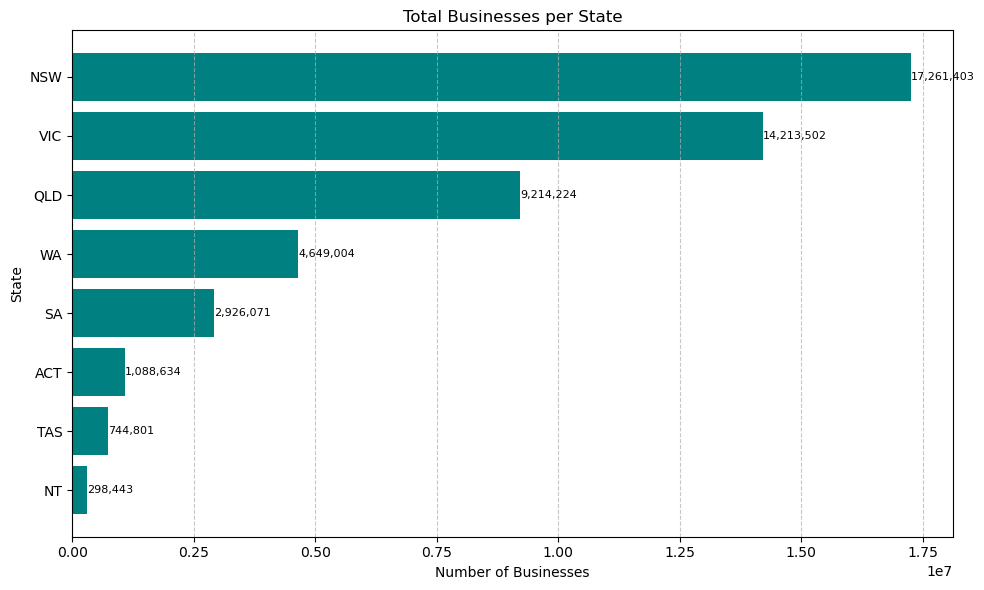

In [530]:
# Barchart Visualisation to show Total Businesses per State

industry_cols = [col for col in data_abs_economy.columns if col not in ['Label', 'Year']]
data_abs_economy[industry_cols] = data_abs_economy[industry_cols].apply(pd.to_numeric, errors='coerce').fillna(0)


data_abs_economy['Label'] = data_abs_economy['Label'].astype(str)
data_abs_economy['Total_Businesses'] = data_abs_economy[industry_cols].sum(axis=1)
total_per_state = data_abs_economy.groupby('Label', as_index=True)['Total_Businesses'].sum().sort_values()


plt.figure(figsize=(10, 6))
bars = plt.barh(total_per_state.index, total_per_state.values, color='teal')

plt.title('Total Businesses per State')
plt.xlabel('Number of Businesses')
plt.ylabel('State')
plt.grid(axis='x', linestyle='--', alpha=0.7)

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{int(bar.get_width()):,}', 
             va='center', ha='left', fontsize=8)

plt.tight_layout()
plt.show()

This chart shows the total number of businesses in each state in Australia. NSW has the highest number of businesses, followed by VIC and QLD, while NT has the lowest. This ranking reflects the concentration of economic activity in states with major population and business hubs such as Sydney (NSW) and Melbourne (VIC).

##### <b> <span style="color:blue">Population Table </span></b>

In [505]:
file_path = "DATA3_ABS/Population_and_people.xlsx"
data_abs_population = pd.read_excel(file_path, sheet_name="Table 1", header=6)
data_abs_population.head()

,Code,Label,Year,Estimated resident population (no.),Population density (persons/km2),Estimated resident population - males (no.),Estimated resident population - females (no.),Median age - males (years),Median age - females (years),Median age - persons (years),...,Australian citizenship not stated (no.),Australian citizen (%),Not an Australian citizen (%),Australian citizenship not stated (%),Speaks a language other than English at home (no.),Speaks a language other than English at home (%),Currently serving in the Australian Defence Force (no.),Previously served in the Australian Defence Force (no.),Currently serving in the Australian Defence Force (%),Previously served in the Australian Defence Force (%)
0,AUS,Australia,2011.0,-,-,-,-,-,-,-,...,1286620,84.9,9.1,6,3912940,18.2,-,-,-,-
1,AUS,Australia,2016.0,-,-,-,-,-,-,-,...,1615597,82.4,10.7,6.9,4871646,20.8,-,-,-,-
2,AUS,Australia,2018.0,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
3,AUS,Australia,2019.0,25334826,3.3,12577221,12757605,36.7,38.4,37.5,...,-,-,-,-,-,-,-,-,-,-
4,AUS,Australia,2020.0,25649248,3.3,12728639,12920609,37,38.7,37.9,...,-,-,-,-,-,-,-,-,-,-


In [528]:
# Convert "-" to nan

data_abs_population = data_abs_population.replace("-", np.nan)

# Convert NaN to 0
data_abs_population = data_abs_population.fillna(0)

for col in data_abs_population.select_dtypes(include=['float']).columns:
    data_abs_population[col] = data_abs_population[col].astype(int)

data_abs_population.head(10)

,Label,Year,Estimated resident population - males (no.),Estimated resident population - females (no.)
0,NSW,2011,0,0
1,NSW,2016,0,0
2,NSW,2018,0,0
3,NSW,2019,3999452,4047296
4,NSW,2020,4030710,4079900
5,NSW,2021,4025393,4071669
6,NSW,2022,4059763,4106941
7,NSW,2023,4149141,4193144
8,NSW,2024,0,0
9,VIC,2011,0,0


Just like we did with the economy and industry table before, here we first convert all "-" values into NaN so pandas can properly identify them as missing data. This ensures that the dataset is clean and consistent before we do any analysis. After that, instead of dropping rows, we replace all remaining NaN values with 0 to keep the dataset complete while making sure all missing values are handled properly. Finally, we convert the Year column into integers so the data is tidy and ready for analysis.


In [508]:
# Keep necessary columns

keep_cols_populationtable = [
    "Label",
    "Year",
    "Estimated resident population - males (no.)",
    "Estimated resident population - females (no.)",
]

In [509]:
data_abs_population = data_abs_population[keep_cols_populationtable]

data_abs_population = data_abs_population[data_abs_population["Label"].isin(state_map.keys())]

data_abs_population["Label"] = data_abs_population["Label"].map(state_map)

In [510]:
data_abs_population = data_abs_population.reset_index(drop=True)
data_abs_population.head()

,Label,Year,Estimated resident population - males (no.),Estimated resident population - females (no.)
0,NSW,2011,0,0
1,NSW,2016,0,0
2,NSW,2018,0,0
3,NSW,2019,3999452,4047296
4,NSW,2020,4030710,4079900


In [511]:
data_abs_population.head()

,Label,Year,Estimated resident population - males (no.),Estimated resident population - females (no.)
0,NSW,2011,0,0
1,NSW,2016,0,0
2,NSW,2018,0,0
3,NSW,2019,3999452,4047296
4,NSW,2020,4030710,4079900


In [512]:
# Check again to confirm there are no missing values left
data_abs_population.isna().sum().sum()

0

In [ ]:
# Save cleaned dataset to a new CSV file
data_abs_population.to_csv("data_abs_population_cleaned.csv", index=False)

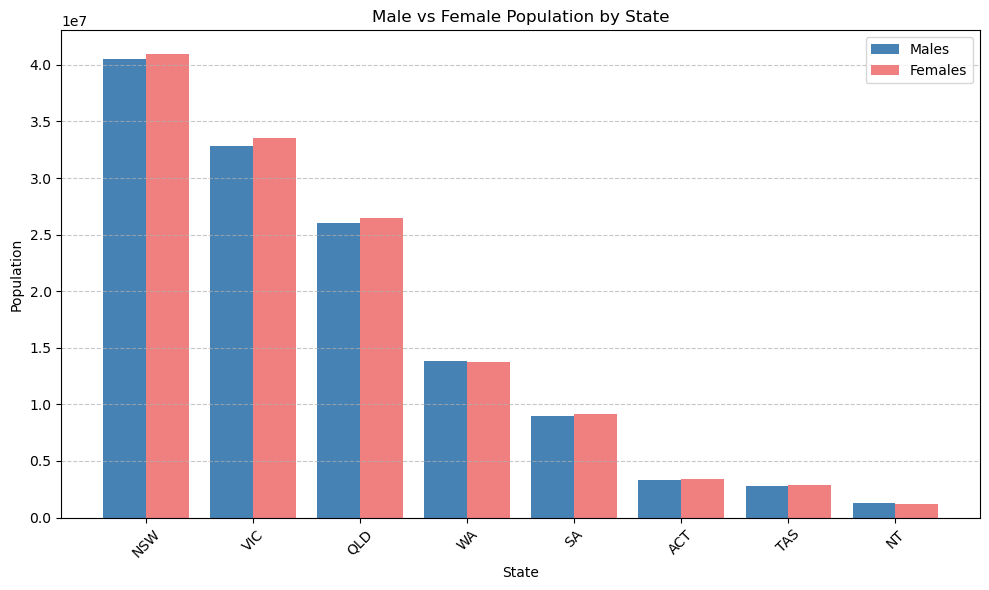

In [526]:
# Pastikan kolom numerik
data_abs_population[['Estimated resident population - males (no.)', 
                     'Estimated resident population - females (no.)']] = (
    data_abs_population[['Estimated resident population - males (no.)', 
                         'Estimated resident population - females (no.)']]
    .apply(pd.to_numeric, errors='coerce')
    .fillna(0)
)

# Group by Label (state) dan hitung total laki + perempuan
population_per_state = data_abs_population.groupby('Label')[[
    'Estimated resident population - males (no.)',
    'Estimated resident population - females (no.)'
]].sum()

# Tambahkan kolom total untuk sorting
population_per_state['Total'] = (population_per_state['Estimated resident population - males (no.)'] +
                                 population_per_state['Estimated resident population - females (no.)'])

# Urutkan dari total terbesar ke terkecil
population_per_state = population_per_state.sort_values('Total', ascending=False)

# Plot bar chart side-by-side
plt.figure(figsize=(10, 6))
bar_width = 0.4
x = range(len(population_per_state))

plt.bar([p - bar_width/2 for p in x], 
        population_per_state['Estimated resident population - males (no.)'], 
        width=bar_width, label='Males', color='steelblue')

plt.bar([p + bar_width/2 for p in x], 
        population_per_state['Estimated resident population - females (no.)'], 
        width=bar_width, label='Females', color='lightcoral')

# Label & Formatting
plt.xticks(x, population_per_state.index, rotation=45)
plt.xlabel('State')
plt.ylabel('Population')
plt.title('Male vs Female Population by State')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

This chart compares the male and female populations by state in Australia. NSW has the highest population for both males and females, followed by VIC and QLD. Across all states, the female population is slightly higher than the male population, but the differences are generally small.

### <b> <span style="color:pink">2.2 Data Integration</span></b>


#### <b> <span style="color:white">a. NGER Data</span></b>


In [ ]:
nger_data = pd.read_csv('NGER_DATA.csv')
nger_data.head()

,Reporting entity,Facility Name,Type,State,Electricity Production GJ,Electricity production MWh,Total scope 1 emissions t CO2 e,Total scope 2 emissions t CO2 e,Total Emissions t CO2 e,Emission intensity t CO2 e MWh,Grid connected,Grid,Primary Fuel,Year,Important Notes
0,ACCIONA ENERGY OCEANIA PTY LTD,Gunning Wind Farm,F,NSW,567719.0,157700.0,19.0,293.0,312,0.00,On,NEM,Wind,2014,NaN
1,ACCIONA ENERGY OCEANIA PTY LTD,Royalla Solar Farm,F,ACT,213115.0,59199.0,0.0,15.0,15,0.00,On,NEM,Solar,2014,NaN
2,ACCIONA ENERGY OCEANIA PTY LTD,Waubra Wind Farm,F,VIC,2461803.0,683834.0,77.0,1144.0,1221,0.00,On,NEM,Wind,2014,NaN
3,AGL ENERGY LIMITED,Banimboola Hydro,F,VIC,137094.0,38082.0,5.0,17.0,22,0.00,On,NEM,Hydro,2014,NaN
4,AGL ENERGY LIMITED,Bayswater Power Station,F,NSW,50275548.0,13965430.0,12253123.0,8306.0,12261429,0.88,On,NEM,Black Coal,2014,NaN


In [ ]:
# Rename the columns
cols = {
        "Reporting entity": "reporting_entity",
        "Facility Name": "facility_name",
        "Type": "type",
        "State": "state",
        "Electricity Production GJ": "electricity_production_gj",
        "Electricity production MWh": "electricity_production_mwh",
        "Total scope 1 emissions t CO2 e": "total_scope1_emissions_tco2e",
        "Total scope 2 emissions t CO2 e": "total_scope2_emissions_tco2e",
        "Total Emissions t CO2 e": "total_emissions_tco2e",
        "Emission intensity t CO2 e MWh": "emission_intensity_tco2e_mwh",
        "Grid connected": "grid_conencted",
        "Grid": "grid",
        "Primary Fuel": "fuel_source",
        "Year": "year",
        "Important Notes": "notes",
    }
nger_data = nger_data.rename(columns=cols)

In [ ]:
nger_data

,reporting_entity,facility_name,type,state,electricity_production_gj,electricity_production_mwh,total_scope1_emissions_tco2e,total_scope2_emissions_tco2e,total_emissions_tco2e,emission_intensity_tco2e_mwh,grid_conencted,grid,fuel_source,year,notes
0,ACCIONA ENERGY OCEANIA PTY LTD,Gunning Wind Farm,F,NSW,567719.0,157700.0,19.0,293.0,312,0.00,On,NEM,Wind,2014,NaN
1,ACCIONA ENERGY OCEANIA PTY LTD,Royalla Solar Farm,F,ACT,213115.0,59199.0,0.0,15.0,15,0.00,On,NEM,Solar,2014,NaN
2,ACCIONA ENERGY OCEANIA PTY LTD,Waubra Wind Farm,F,VIC,2461803.0,683834.0,77.0,1144.0,1221,0.00,On,NEM,Wind,2014,NaN
3,AGL ENERGY LIMITED,Banimboola Hydro,F,VIC,137094.0,38082.0,5.0,17.0,22,0.00,On,NEM,Hydro,2014,NaN
4,AGL ENERGY LIMITED,Bayswater Power Station,F,NSW,50275548.0,13965430.0,12253123.0,8306.0,12261429,0.88,On,NEM,Black Coal,2014,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,ARET PLATFORM PTY LIMITED,Willogoleche Wind Farm,F,SA,1090576.0,302938.0,70.0,137.0,207,0.00,On,NEM,Wind,2023,NaN
4826,WINTON HOLDINGS CO PTY. LTD,Winton Solar Farm,F,VIC,532678.0,147966.0,33.0,0.0,33,0.00,On,NEM,Solar,2023,NaN
4827,WIRTGEN ENERGY GLENROWAN PTY. LTD,Glenrowan West Solar Farm,F,VIC,766484.0,212912.0,60.0,543.0,603,0.00,On,NEM,Solar,2023,NaN
4828,WOOLOOGA HOLDCO 2 PTY LTD,Woolooga SF,F,QLD,1185741.0,329373.0,59.0,3658.0,3717,0.00,On,NEM,Solar,2023,NaN


#### <b> <span style="color:white">b. CER Data</span></b>


We integrate the 3 tables (approved, committed, and probable) into one table.


In [ ]:
# Read the cleaned dataset first
cer_approved = pd.read_csv("DATA2_LRET/approved_power_stations_cleaned.csv")
cer_committed = pd.read_csv("DATA2_LRET/committed_power_stations_cleaned.csv")
cer_probable = pd.read_csv("DATA2_LRET/probable_power_stations_cleaned.csv")

In [ ]:
# Function to integrate
def integrate_cer(df_approved: pd.DataFrame, df_committed: pd.DataFrame, df_probable: pd.DataFrame):
    # Approved dataframe
    approved = df_approved.copy()
    approved.rename(columns={'approval_date': 'stage_date'}, inplace=True)

    # Committed dataframe
    committed = df_committed.copy()
    committed.rename(columns={'committed_month': 'stage_date'}, inplace=True)
    committed = committed.assign(
        postcode = pd.NA,
        accreditation_code = pd.NA,
        accreditation_start_date = pd.NaT,
    )

    # Probable dataframe
    probable = df_probable.copy()
    probable = probable.assign(
        postcode = pd.NA,
        accreditation_code = pd.NA,
        accreditation_start_date = pd.NaT,
        stage_date = pd.NaT,
    )

    # Final columns in the unified dataframe
    final_columns = ["project_name", "state", "postcode", "fuel_source", "capacity_mw", "project_stage", "stage_date", "accreditation_start_date", "accreditation_code"]

    final_df = pd.concat([approved[final_columns], committed[final_columns], probable[final_columns]], ignore_index=True)
    final_df["accreditation_start_date"] = pd.to_datetime(final_df["accreditation_start_date"], errors="coerce")
    final_df["stage_date"] = pd.to_datetime(final_df["stage_date"], errors="coerce")

    return final_df

In [ ]:
# Integrate the 3 tables
cer_integrated_df = integrate_cer(cer_approved, cer_committed, cer_probable)

In [ ]:
# Check for final dataframe
cer_integrated_df.head(10)

,project_name,state,postcode,fuel_source,capacity_mw,project_stage,stage_date,accreditation_start_date,accreditation_code
0,"Laura Johnson Home, Townview",QLD,4825,Solar,0.2265,approved,2025-01-13,2024-10-15,SRPXQLE8
1,Leppington,NSW,2179,Solar,0.7320,approved,2025-01-13,2024-11-22,SRPYNS39
2,Quakers Hillside Care Community,NSW,2763,Solar,0.1996,approved,2025-01-13,2024-12-19,SRPYNS58
3,Rest Nominees,VIC,3008,Solar,0.1188,approved,2025-01-13,2024-09-20,SRPXVCN4
4,Retail First Mt Ommaney,QLD,4074,Solar,1.0004,approved,2025-01-13,2024-10-29,SRPXQLF9
5,Woolworths HCFDC Heathwood,QLD,4110,Solar,1.6721,approved,2025-01-13,2024-12-12,SRPXQLG3
6,Woolworths Kings Meadow 7210,TAS,7249,Solar,0.2926,approved,2025-01-13,2024-11-18,SRPVTA25
7,CLAYTON CHURCH HOMES INC- ELIZABETH PARK,SA,5113,Solar,0.1965,approved,2025-01-17,2024-12-11,SRPVSAY5
8,Dalwood Children's Home,NSW,2092,Solar,0.2465,approved,2025-01-17,2024-12-19,SRPYNS57
9,Haighs Proprietary Limited - Salisbury South,SA,5106,Solar,0.6265,approved,2025-01-17,2024-12-27,SRPVSAY1


## <b> <span style="color:orange">3. Data Augmentation</span></b>


Note:  
Augment your integrated dataset about large-scale power stations with their geo-location by programmatically querying the geographic coordinates  
using a public geocoding API (such as Google Maps or OpenStreetMap/Nominatim) for all the energy facilities present.  
Document methods and API usage.


First, we create some required functions to simplify the augmentation process. We define 3 functions:

1. The make_search_text function to create the search text for OSM API.
2. The get_address_details function to get the location data using OSM API.
3. The map_result function to map the result into a dict, for easier processing later.


In [ ]:
# Make search string function first
def make_search_text(name: str, state=None, postcode=None):
    text = [name]
    if pd.notna(state):
        text.append(str(state).strip().upper())
    if pd.notna(postcode):
        text.append(str(postcode).strip().zfill(4))
    text.append('Australia')
    return ", ".join([p for p in text if p])

# Function to get location result from OpenStreetMap API
def get_address_details(params, useragent, wait=1):
    base_url = 'https://nominatim.openstreetmap.org/search'
    headers = {'User-Agent': useragent}
    t.sleep(wait)  
    response = requests.get(base_url, params = params, headers = headers)
    return response.json()

# Map the result to a dictionary
def map_result(res, search_text, resolution):
    loc_result = {
            "search_text": search_text, "lat": float(res.get("lat")), "lon": float(res.get("lon")), 
            "min_lat": res.get("boundingbox")[0], "max_lat": res.get("boundingbox")[1], 
            "min_lon": res.get("boundingbox")[2], "max_lon": res.get("boundingbox")[3], 
            "display_name": res.get("display_name"),
            "osm_type": res.get("osm_type"), "osm_id": res.get("osm_id"), "geocoder": "nominatim", "status": "ok",
            "geo_resolution": resolution,
        }
    return loc_result

Next, we create a dataframe that contains the location information for each state in Australia. This is important so we can use the state information if our search does not return any results. Putting the information in a dataframe and use it whenever we need it will greatly reduce the traffic because this way, we wouldn't need to make an API call everytime for each row with zero results.


In [ ]:
# Geocode state first. This will be used as geocode information substitute when name and postcode information returns zero results.  
state_name = {
    "NSW":"New South Wales","VIC":"Victoria","QLD":"Queensland","SA":"South Australia",
    "WA":"Western Australia","TAS":"Tasmania","NT":"Northern Territory","ACT":"Australian Capital Territory"
}

df_states = (pd.DataFrame(state_name.items(), columns=["state_code","state_name"])
               .sort_values("state_code")
               .reset_index(drop=True))

user_agent = 'COMP5339-TUT07-GROUP04'
out_rows = []

for _, row in df_states.iterrows():
    name = row['state_name']
    search_text = make_search_text(name)
    params = {'q': search_text, 'format': 'json', 'addressdetails': 0, 'countrycodes': 'au'}
    result = get_address_details(params, useragent=user_agent)

    if result:
        x = result[0]
        loc_result = map_result(x, search_text, "state")

    out_rows.append(loc_result) 

state_geo = pd.DataFrame(out_rows, index=df_states.index)
state_geo = pd.concat([df_states.reset_index(drop=True), state_geo.reset_index(drop=True)], axis=1)

Next, we define the get_geocode function, which is our main function to get the location information from OSM API. We first make an API call with complete information. If that returns zero results (location not found), we mitigate with postcode+state search instead. If that also fails, we use the state information we have retrieved before. We state the resolution in the resulotion flag to store the information whether the location is exact, based on postcode, or based on state.


In [ ]:
def get_geocode(df: pd.DataFrame, name_col="project_name", state_col=None, postcode_col=None, ua="useragent"):
    user_agent = ua
    out_rows = []

    for _, row in df.iterrows():
        name = row[name_col]
        state = row[state_col]
        postcode = row.get(postcode_col, None)
        search_text = make_search_text(name, state, postcode)
        params = {'q': search_text, 'format': 'json', 'addressdetails': 0, 'countrycodes': 'au'}
        result = get_address_details(params, useragent=user_agent)

        if result:
            x = result[0]
            loc_result = map_result(x, search_text, "exact")
        else:
            if pd.notna(postcode):
                search_text = make_search_text("", state, postcode)
                params = {'q': search_text, 'format': 'json', 'addressdetails': 0, 'countrycodes': 'au'}
                result = get_address_details(params, useragent=user_agent)
                x = result[0]
                loc_result = map_result(x, search_text, "postcode")
            else:
                # match with state_geo dataframe
                x = (state_geo.loc[state_geo['state_code'].eq(state)]).iloc[0]
                loc_result = {
                    "search_text": search_text, "lat": float(x.get("lat")), "lon": float(x.get("lon")), 
                    "min_lat": float(x.get("min_lat")), "max_lat": float(x.get("max_lat")), 
                    "min_lon": float(x.get("min_lon")), "max_lon": float(x.get("max_lon")), 
                    "display_name": x.get("display_name"),
                    "osm_type": x.get("osm_type"), "osm_id": x.get("osm_id"), "geocoder": "nominatim", "status": "ok",
                    "geo_resolution": "state",
                }

        out_rows.append(loc_result) 

    geo = pd.DataFrame(out_rows, index=df.index)
    return pd.concat([df.reset_index(drop=True), geo.reset_index(drop=True)], axis=1)

#### <b> <span style="color:white">a. NGER Data</span></b>


In [ ]:
# Copy the df first
nger_copy = nger_data.copy()

# Augment the row with geolocation
nger_aug_df = get_geocode(nger_copy, name_col="facility_name", state_col="state", postcode_col=None)

In [ ]:
nger_aug_df

,reporting_entity,facility_name,type,state,electricity_production_gj,electricity_production_mwh,total_scope1_emissions_tco2e,total_scope2_emissions_tco2e,total_emissions_tco2e,emission_intensity_tco2e_mwh,...,min_lat,max_lat,min_lon,max_lon,display_name,osm_type,osm_id,geocoder,status,geo_resolution
0,ACCIONA ENERGY OCEANIA PTY LTD,Gunning Wind Farm,F,NSW,567719.0,157700.0,19.0,293.0,312,0.00,...,-37.528014,-28.141526,140.999272,159.339031,"New South Wales, Australia",relation,2316593,nominatim,ok,state
1,ACCIONA ENERGY OCEANIA PTY LTD,Royalla Solar Farm,F,ACT,213115.0,59199.0,0.0,15.0,15,0.00,...,-35.92053,-35.124413,148.762799,149.399297,"Australian Capital Territory, Australia",relation,2354197,nominatim,ok,state
2,ACCIONA ENERGY OCEANIA PTY LTD,Waubra Wind Farm,F,VIC,2461803.0,683834.0,77.0,1144.0,1221,0.00,...,-37.3529060,-37.3527976,143.6312432,143.6313944,"Waubra Wind Farm Information, Sunraysia Highwa...",way,203440016,nominatim,ok,exact
3,AGL ENERGY LIMITED,Banimboola Hydro,F,VIC,137094.0,38082.0,5.0,17.0,22,0.00,...,-39.198487,-33.980797,140.961902,150.033282,"Victoria, Australia",relation,2316741,nominatim,ok,state
4,AGL ENERGY LIMITED,Bayswater Power Station,F,NSW,50275548.0,13965430.0,12253123.0,8306.0,12261429,0.88,...,-32.3995382,-32.3907834,150.9433910,150.9558083,"Bayswater Power Station, Muswellbrook, Muswell...",way,171863884,nominatim,ok,exact
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,ARET PLATFORM PTY LIMITED,Willogoleche Wind Farm,F,SA,1090576.0,302938.0,70.0,137.0,207,0.00,...,-33.4460186,-33.3869837,138.8195719,138.8659669,"Willogoleche Wind Farm, Hallett, The Regional ...",way,1084127006,nominatim,ok,exact
4826,WINTON HOLDINGS CO PTY. LTD,Winton Solar Farm,F,VIC,532678.0,147966.0,33.0,0.0,33,0.00,...,-39.198487,-33.980797,140.961902,150.033282,"Victoria, Australia",relation,2316741,nominatim,ok,state
4827,WIRTGEN ENERGY GLENROWAN PTY. LTD,Glenrowan West Solar Farm,F,VIC,766484.0,212912.0,60.0,543.0,603,0.00,...,-39.198487,-33.980797,140.961902,150.033282,"Victoria, Australia",relation,2316741,nominatim,ok,state
4828,WOOLOOGA HOLDCO 2 PTY LTD,Woolooga SF,F,QLD,1185741.0,329373.0,59.0,3658.0,3717,0.00,...,-29.179266,-9.088012,137.994646,153.611604,"Queensland, Australia",relation,2316595,nominatim,ok,state


In [ ]:
# Save to a new csv file
nger_aug_df.to_csv("nger_augmented.csv")

#### <b> <span style="color:white">b. CER Data</span></b>


In [ ]:
# Copy the df first
cer_copy = cer_integrated_df.copy()

# Augment the row with geolocation
cer_aug_df = get_geocode(cer_copy, name_col="project_name", state_col="state", postcode_col="postcode")


In [ ]:
cer_aug_df

,project_name,state,postcode,fuel_source,capacity_mw,project_stage,stage_date,accreditation_start_date,accreditation_code,search_text,...,min_lat,max_lat,min_lon,max_lon,display_name,osm_type,osm_id,geocoder,status,geo_resolution
0,"Laura Johnson Home, Townview",QLD,4825,Solar,0.2265,approved,2025-01-13,2024-10-15,SRPXQLE8,"QLD, 4825, Australia",...,-20.7290552,-20.7289552,139.4931736,139.4932736,"Mount Isa Post Office, Isa Street, Mount Isa C...",node,289547296,nominatim,ok,postcode
1,Leppington,NSW,2179,Solar,0.7320,approved,2025-01-13,2024-11-22,SRPYNS39,"Leppington, NSW, 2179, Australia",...,-34.0043308,-33.9483242,150.7594078,150.8413822,"Leppington, Sydney, Camden Council, New South ...",relation,5519705,nominatim,ok,exact
2,Quakers Hillside Care Community,NSW,2763,Solar,0.1996,approved,2025-01-13,2024-12-19,SRPYNS58,"Quakers Hillside Care Community, NSW, 2763, Au...",...,-33.7197667,-33.7196667,150.8921698,150.8922698,"Quakers Hillside Care Community, Hambledon Rd,...",node,2918464324,nominatim,ok,exact
3,Rest Nominees,VIC,3008,Solar,0.1188,approved,2025-01-13,2024-09-20,SRPXVCN4,"VIC, 3008, Australia",...,-37.8180667,-37.8170121,144.9696033,144.9703389,"Ian Potter Centre: NGV Australia, Russell Stre...",way,22963243,nominatim,ok,postcode
4,Retail First Mt Ommaney,QLD,4074,Solar,1.0004,approved,2025-01-13,2024-10-29,SRPXQLF9,"QLD, 4074, Australia",...,-27.5422586,-27.5411197,153.0788750,153.0796915,"Hillsong Brisbane Campus, 16, Rover Street, Mo...",relation,15268146,nominatim,ok,postcode
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,Walgett Solar Farm,NSW,<NA>,Solar,25.0000,probable,NaT,NaT,NaN,"Walgett Solar Farm, NSW, Australia",...,-37.528014,-28.141526,140.999272,159.339031,"New South Wales, Australia",relation,2316593,nominatim,ok,state
360,Waroona Solar Fam,WA,<NA>,Solar,120.0000,probable,NaT,NaT,NaN,"Waroona Solar Fam, WA, Australia",...,-35.24185,-13.507685,112.86567,129.002049,"Western Australia, Australia",relation,2316598,nominatim,ok,state
361,West Mokoan Solar Farm,VIC,<NA>,Solar,300.0000,probable,NaT,NaT,NaN,"West Mokoan Solar Farm, VIC, Australia",...,-39.198487,-33.980797,140.961902,150.033282,"Victoria, Australia",relation,2316741,nominatim,ok,state
362,Winton North Solar Farm,VIC,<NA>,Solar,100.0000,probable,NaT,NaT,NaN,"Winton North Solar Farm, VIC, Australia",...,-39.198487,-33.980797,140.961902,150.033282,"Victoria, Australia",relation,2316741,nominatim,ok,state


In [ ]:
# Save to a new csv file
cer_aug_df.to_csv("cer_augmented.csv")

#### <b> <span style="color:white">c. ABS Data</span></b>


In [ ]:
abs_economy = pd.read_csv('data_abs_economy_cleaned.csv')
out_rows = []

for _, row in abs_economy.iterrows():
    state = row['Label']
    x = (state_geo.loc[state_geo['state_code'].eq(state)]).iloc[0]

    loc_result = {
                    "search_text": search_text, "lat": float(x.get("lat")), "lon": float(x.get("lon")), 
                    "min_lat": float(x.get("min_lat")), "max_lat": float(x.get("max_lat")), 
                    "min_lon": float(x.get("min_lon")), "max_lon": float(x.get("max_lon")), 
                    "display_name": x.get("display_name"),
                    "osm_type": x.get("osm_type"), "osm_id": x.get("osm_id"), "geocoder": "nominatim", "status": "ok",
                    "geo_resolution": "state",
                }
    out_rows.append(loc_result) 

geo = pd.DataFrame(out_rows, index=abs_economy.index)
abs_economy_augmented = pd.concat([abs_economy.reset_index(drop=True), geo.reset_index(drop=True)], axis=1)

In [ ]:
abs_population = pd.read_csv('data_abs_population_cleaned.csv')
out_rows = []

for _, row in abs_population.iterrows():
    state = row['Label']
    x = (state_geo.loc[state_geo['state_code'].eq(state)]).iloc[0]

    loc_result = {
                    "search_text": search_text, "lat": float(x.get("lat")), "lon": float(x.get("lon")), 
                    "min_lat": float(x.get("min_lat")), "max_lat": float(x.get("max_lat")), 
                    "min_lon": float(x.get("min_lon")), "max_lon": float(x.get("max_lon")), 
                    "display_name": x.get("display_name"),
                    "osm_type": x.get("osm_type"), "osm_id": x.get("osm_id"), "geocoder": "nominatim", "status": "ok",
                    "geo_resolution": "state",
                }
    out_rows.append(loc_result) 

geo = pd.DataFrame(out_rows, index=abs_population.index)
abs_population_augmented = pd.concat([abs_population.reset_index(drop=True), geo.reset_index(drop=True)], axis=1)

In [ ]:
# Save to a new csv file
abs_economy_augmented.to_csv("abs_economy_augmented.csv")
abs_population_augmented.to_csv("abs_population_augmented.csv")

## <b> <span style="color:orange">4. Data Transformation and Storage</span></b>


Transform the processed and augmented data into a structured format suitable for analysis and visualization.  
Specifically, you should:  
• design a suitable database schema for storage in database, and  
• implement this schema and store your data in either DuckDB or a PostgreSQL database.

Whichever system you choose to install, make sure you include the spatial extensions so that we can run some spatial queries in Assignment 2.  
This should be straight-forward for DuckDB, but when choosing PostgreSQL,  
make sure PostGIS is included in the chosen install package.

Important Note: Clearly justify your database design decisions (e.g., normalized or deformalized schema) in your project report.  
If your group encounters significant difficulties working with a database, you may alternatively store your data in separate CSV files;  
however, choosing CSV storage will result in a mark penalty.


### <b> <span style="color:pink">4.1 Data Definition Language (DDL)</span></b>

#### <b> <span style="color:white">a. Table: dim_geo</span></b>


In [ ]:
DB_PATH = "energy_dw.duckdb"
SCHEMA  = "public"
OUT_DIR = Path("out")

con = duckdb.connect(DB_PATH)
con.execute(f'CREATE SCHEMA IF NOT EXISTS "{SCHEMA}";')

# DDL
ddl = dedent(f"""
DROP TABLE IF EXISTS "{SCHEMA}"."dim_geo";
CREATE TABLE "{SCHEMA}"."dim_geo" (
    geo_id           INTEGER  NOT NULL PRIMARY KEY,
    latitude         DOUBLE   NOT NULL,
    longitude        DOUBLE   NOT NULL,
    state_code       TEXT     NOT NULL,
    display_name     TEXT     NOT NULL,
    postcode         TEXT,
    min_latitude     DOUBLE   NOT NULL,
    max_latitude     DOUBLE   NOT NULL,
    min_longitude    DOUBLE   NOT NULL,
    max_longitude    DOUBLE   NOT NULL,
    osm_type         TEXT     NOT NULL,
    geocoder         TEXT     NOT NULL,
    geo_resolution   TEXT     NOT NULL,
    search_text_used TEXT     NOT NULL
);
""").strip()

con.execute(ddl)

# Save DDL
OUT_DIR.mkdir(parents=True, exist_ok=True)
(OUT_DIR / "ddl_dim_geo_duckdb.sql").write_text(ddl + "\n", encoding="utf-8")

# Quick verify
print(con.execute(f"PRAGMA table_info('{SCHEMA}.dim_geo');").fetchdf())

con.close()


    cid              name     type  notnull dflt_value     pk
0     0            geo_id  INTEGER     True       None   True
1     1          latitude   DOUBLE     True       None  False
2     2         longitude   DOUBLE     True       None  False
3     3        state_code  VARCHAR     True       None  False
4     4      display_name  VARCHAR     True       None  False
5     5          postcode  VARCHAR    False       None  False
6     6      min_latitude   DOUBLE     True       None  False
7     7      max_latitude   DOUBLE     True       None  False
8     8     min_longitude   DOUBLE     True       None  False
9     9     max_longitude   DOUBLE     True       None  False
10   10          osm_type  VARCHAR     True       None  False
11   11          geocoder  VARCHAR     True       None  False
12   12    geo_resolution  VARCHAR     True       None  False
13   13  search_text_used  VARCHAR     True       None  False


#### <b> <span style="color:white">b. Table: dim_corporation</span></b>


In [ ]:
DB_PATH = "energy_dw.duckdb"
SCHEMA  = "public"
OUT_DIR = Path("out")

con = duckdb.connect(DB_PATH)
con.execute(f'CREATE SCHEMA IF NOT EXISTS "{SCHEMA}";')

ddl = dedent(f"""
-- Create a sequence for auto-increment
DROP SEQUENCE IF EXISTS "{SCHEMA}".seq_corporation_id;
CREATE SEQUENCE "{SCHEMA}".seq_corporation_id START 1;

-- Recreate the table
DROP TABLE IF EXISTS "{SCHEMA}"."dim_corporation";
CREATE TABLE "{SCHEMA}"."dim_corporation" (
    corporation_id   INTEGER NOT NULL
        DEFAULT nextval('{SCHEMA}.seq_corporation_id')
        PRIMARY KEY,
    corporation_name TEXT    NOT NULL
);
""").strip()

con.execute(ddl)

# Save DDL
OUT_DIR.mkdir(parents=True, exist_ok=True)
(OUT_DIR / "ddl_dim_corporation_duckdb.sql").write_text(ddl + "\n", encoding="utf-8")

# Verify
print(con.execute(f"PRAGMA table_info('{SCHEMA}.dim_corporation');").fetchdf())

con.close()


   cid              name     type  notnull                            dflt_value     pk
0    0    corporation_id  INTEGER     True  nextval('public.seq_corporation_id')   True
1    1  corporation_name  VARCHAR     True                                  None  False


#### <b> <span style="color:white">c. Table: dim_facility</span></b>


In [ ]:
DB_PATH = "energy_dw.duckdb"
SCHEMA  = "public"
OUT_DIR = Path("out")

con = duckdb.connect(DB_PATH)
con.execute(f'CREATE SCHEMA IF NOT EXISTS "{SCHEMA}";')

ddl = dedent(f"""
-- Sequence for auto-increment (compatible across DuckDB versions)
DROP SEQUENCE IF EXISTS "{SCHEMA}".seq_facility_id;
CREATE SEQUENCE "{SCHEMA}".seq_facility_id START 1;

-- Recreate table with strict column order
DROP TABLE IF EXISTS "{SCHEMA}"."dim_facility";
CREATE TABLE "{SCHEMA}"."dim_facility" (
    facility_id   INTEGER NOT NULL
        DEFAULT nextval('{SCHEMA}.seq_facility_id')
        PRIMARY KEY,
    facility_name TEXT    NOT NULL
);
""").strip()

con.execute(ddl)

# Save DDL
OUT_DIR.mkdir(parents=True, exist_ok=True)
(OUT_DIR / "ddl_dim_facility_duckdb.sql").write_text(ddl + "\n", encoding="utf-8")

# Verify
print(con.execute(f"PRAGMA table_info('{SCHEMA}.dim_facility');").fetchdf())

con.close()


   cid           name     type  notnull                         dflt_value     pk
0    0    facility_id  INTEGER     True  nextval('public.seq_facility_id')   True
1    1  facility_name  VARCHAR     True                               None  False


#### <b> <span style="color:white">d. Table: dim_fuel</span></b>


In [ ]:
DB_PATH = "energy_dw.duckdb"
SCHEMA  = "public"
OUT_DIR = Path("out")

con = duckdb.connect(DB_PATH)
con.execute(f'CREATE SCHEMA IF NOT EXISTS "{SCHEMA}";')

ddl = dedent(f"""
-- Sequence for auto-increment key (compatible across DuckDB versions)
DROP SEQUENCE IF EXISTS "{SCHEMA}".seq_fuel_key;
CREATE SEQUENCE "{SCHEMA}".seq_fuel_key START 1;

-- Recreate table with strict column order
DROP TABLE IF EXISTS "{SCHEMA}"."dim_fuel";
CREATE TABLE "{SCHEMA}"."dim_fuel" (
    fuel_key      INTEGER NOT NULL
        DEFAULT nextval('{SCHEMA}.seq_fuel_key')
        PRIMARY KEY,
    fuel_type     TEXT    NOT NULL,
    fuel_category TEXT    NOT NULL,
    is_renewable  BOOLEAN NOT NULL,

    -- Business rules
    UNIQUE (fuel_type),
    CHECK (is_renewable IN (TRUE, FALSE))
    -- Optional strict domain for categories (uncomment to enforce)
    -- , CHECK (fuel_category IN ('SOLAR','WIND','HYDRO','BIO','GAS','LIQUID','COAL','HYBRID','STORAGE','OTHER'))
);
""").strip()

con.execute(ddl)

# Save DDL
OUT_DIR.mkdir(parents=True, exist_ok=True)
(OUT_DIR / "ddl_dim_fuel_duckdb.sql").write_text(ddl + "\n", encoding="utf-8")

# Verify
print(con.execute(f"PRAGMA table_info('{SCHEMA}.dim_fuel');").fetchdf())

con.close()


   cid           name     type  notnull                      dflt_value     pk
0    0       fuel_key  INTEGER     True  nextval('public.seq_fuel_key')   True
1    1      fuel_type  VARCHAR     True                            None  False
2    2  fuel_category  VARCHAR     True                            None  False
3    3   is_renewable  BOOLEAN     True                            None  False


#### <b> <span style="color:white">e. Table: dim_stage</span></b>


In [ ]:
DB_PATH = "energy_dw.duckdb"
SCHEMA  = "public"
OUT_DIR = Path("out")

con = duckdb.connect(DB_PATH)
con.execute(f'CREATE SCHEMA IF NOT EXISTS "{SCHEMA}";')

ddl = dedent(f"""
-- Recreate table with strict column order (no auto-increment)
DROP TABLE IF EXISTS "{SCHEMA}"."dim_stage";
CREATE TABLE "{SCHEMA}"."dim_stage" (
    stage_key   INTEGER NOT NULL
        PRIMARY KEY,
    stage_name  TEXT    NOT NULL,

    -- Business rules
    UNIQUE (stage_name),
    CHECK (stage_key IN (1, 2, 3))
    -- Optional strict domain for names
    -- , CHECK (LOWER(stage_name) IN ('approved','committed','probable'))
);
""").strip()

con.execute(ddl)

# Save DDL
OUT_DIR.mkdir(parents=True, exist_ok=True)
(OUT_DIR / "ddl_dim_stage_duckdb.sql").write_text(ddl + "\n", encoding="utf-8")

# Verify
print(con.execute(f"PRAGMA table_info('{SCHEMA}.dim_stage');").fetchdf())

con.close()


   cid        name     type  notnull dflt_value     pk
0    0   stage_key  INTEGER     True       None   True
1    1  stage_name  VARCHAR     True       None  False


#### <b> <span style="color:white">f. Table: dim_industry</span></b>


In [84]:
DB_PATH = "energy_dw.duckdb"
SCHEMA  = "public"
OUT_DIR = Path("out")

con = duckdb.connect(DB_PATH)
con.execute(f'CREATE SCHEMA IF NOT EXISTS "{SCHEMA}";')

ddl = dedent(f"""
-- Sequence for auto-increment key (compatible across DuckDB versions)
DROP SEQUENCE IF EXISTS "{SCHEMA}".seq_industry_key;
CREATE SEQUENCE "{SCHEMA}".seq_industry_key START 1;

-- Recreate table with strict column order
DROP TABLE IF EXISTS "{SCHEMA}"."dim_industry";
CREATE TABLE "{SCHEMA}"."dim_industry" (
    industry_key  INTEGER NOT NULL
        DEFAULT nextval('{SCHEMA}.seq_industry_key')
        PRIMARY KEY,
    industry_name TEXT    NOT NULL,

    -- Business rule: each industry name must be unique
    UNIQUE (industry_name)
);
""").strip()

con.execute(ddl)

# Save DDL
OUT_DIR.mkdir(parents=True, exist_ok=True)
(OUT_DIR / "ddl_dim_industry_duckdb.sql").write_text(ddl + "\n", encoding="utf-8")

# Verify
print(con.execute(f"PRAGMA table_info('{SCHEMA}.dim_industry');").fetchdf())

con.close()


   cid           name     type  notnull                          dflt_value     pk
0    0   industry_key  INTEGER     True  nextval('public.seq_industry_key')   True
1    1  industry_name  VARCHAR     True                                None  False


#### <b> <span style="color:white">g. Table: fact_nger_facility</span></b>


In [ ]:
DB_PATH = "energy_dw.duckdb"
SCHEMA  = "public"
OUT_DIR = Path("out")

con = duckdb.connect(DB_PATH)
con.execute(f'CREATE SCHEMA IF NOT EXISTS "{SCHEMA}";')

ddl = dedent(f"""
-- Recreate table with strict column order
DROP TABLE IF EXISTS "{SCHEMA}"."fact_nger_facility";
CREATE TABLE "{SCHEMA}"."fact_nger_facility" (
    -- Keys
    year                INTEGER      NOT NULL,
    geo_id              INTEGER      NOT NULL,   -- FK -> dim_geo(geo_id)
    corporation_id      INTEGER      NOT NULL,   -- FK -> dim_corporation(corporation_id)
    facility_id         INTEGER      NOT NULL,   -- FK -> dim_facility(facility_id)

    -- Measures
    electricity_gj        DECIMAL(18,3),
    electricity_mwh       DECIMAL(18,3),
    emissions_1           DECIMAL(18,3),
    emissions_2           DECIMAL(18,3),
    emissions_total       DECIMAL(18,3),
    emissions_intensity   DECIMAL(18,3),

    -- Attributes
    grid_connected      BOOLEAN,
    grid                VARCHAR(16),
    fuel_key            INTEGER,                 -- FK -> dim_fuel(fuel_key)

    -- Constraints
    PRIMARY KEY (year, facility_id),
    CHECK (grid IN ('NEM','SWIS','Off-grid','NWIS','Mt Isa','DKIS')),

    -- Foreign Keys (DuckDB supports simple FKs)
    FOREIGN KEY (geo_id)         REFERENCES "{SCHEMA}"."dim_geo"(geo_id),
    FOREIGN KEY (corporation_id) REFERENCES "{SCHEMA}"."dim_corporation"(corporation_id),
    FOREIGN KEY (facility_id)    REFERENCES "{SCHEMA}"."dim_facility"(facility_id),
    FOREIGN KEY (fuel_key)       REFERENCES "{SCHEMA}"."dim_fuel"(fuel_key)
);
""").strip()

con.execute(ddl)

# Save DDL
OUT_DIR.mkdir(parents=True, exist_ok=True)
(OUT_DIR / "ddl_fact_nger_facility_duckdb.sql").write_text(ddl + "\n", encoding="utf-8")

# Verify
print(con.execute(f"PRAGMA table_info('{SCHEMA}.fact_nger_facility');").fetchdf())

con.close()


    cid                 name           type  notnull dflt_value     pk
0     0                 year        INTEGER     True       None   True
1     1               geo_id        INTEGER     True       None  False
2     2       corporation_id        INTEGER     True       None  False
3     3          facility_id        INTEGER     True       None   True
4     4       electricity_gj  DECIMAL(18,3)    False       None  False
5     5      electricity_mwh  DECIMAL(18,3)    False       None  False
6     6          emissions_1  DECIMAL(18,3)    False       None  False
7     7          emissions_2  DECIMAL(18,3)    False       None  False
8     8      emissions_total  DECIMAL(18,3)    False       None  False
9     9  emissions_intensity  DECIMAL(18,3)    False       None  False
10   10       grid_connected        BOOLEAN    False       None  False
11   11                 grid        VARCHAR    False       None  False
12   12             fuel_key        INTEGER    False       None  False


#### <b> <span style="color:white">h. Table: fact_cer_project</span></b>


In [86]:
DB_PATH = "energy_dw.duckdb"
SCHEMA  = "public"
OUT_DIR = Path("out")

con = duckdb.connect(DB_PATH)
con.execute(f'CREATE SCHEMA IF NOT EXISTS "{SCHEMA}";')

ddl = dedent(f"""
-- Sequence for auto-increment project_id
DROP SEQUENCE IF EXISTS "{SCHEMA}".seq_project_id;
CREATE SEQUENCE "{SCHEMA}".seq_project_id START 1;

-- Recreate table
DROP TABLE IF EXISTS "{SCHEMA}"."fact_cer_project";
CREATE TABLE "{SCHEMA}"."fact_cer_project" (
    -- Order
    stage_date          DATE         NOT NULL,
    year                INTEGER      NOT NULL,  -- derived from stage_date by ETL (DDL keeps it as INT)
    geo_id              INTEGER      NOT NULL,  -- FK -> dim_geo(geo_id)
    project_id          INTEGER      NOT NULL
        DEFAULT nextval('{SCHEMA}.seq_project_id')
        PRIMARY KEY,
    project_name        TEXT         NOT NULL,
    stage_key           INTEGER      NOT NULL,  -- FK -> dim_stage(stage_key)
    fuel_key            INTEGER,                -- FK -> dim_fuel(fuel_key)
    capacity_mw         DECIMAL(12,3),
    accreditation_code  TEXT,
    accreditation_date  DATE,

    -- Foreign keys
    FOREIGN KEY (geo_id)    REFERENCES "{SCHEMA}"."dim_geo"(geo_id),
    FOREIGN KEY (stage_key) REFERENCES "{SCHEMA}"."dim_stage"(stage_key),
    FOREIGN KEY (fuel_key)  REFERENCES "{SCHEMA}"."dim_fuel"(fuel_key)
);
""").strip()

con.execute(ddl)

# Save DDL
OUT_DIR.mkdir(parents=True, exist_ok=True)
(OUT_DIR / "ddl_fact_cer_project_duckdb.sql").write_text(ddl + "\n", encoding="utf-8")

# Verify
print(con.execute(f"PRAGMA table_info('{SCHEMA}.fact_cer_project');").fetchdf())

con.close()


   cid                name           type  notnull                        dflt_value     pk
0    0          stage_date           DATE     True                              None  False
1    1                year        INTEGER     True                              None  False
2    2              geo_id        INTEGER     True                              None  False
3    3          project_id        INTEGER     True  nextval('public.seq_project_id')   True
4    4        project_name        VARCHAR     True                              None  False
5    5           stage_key        INTEGER     True                              None  False
6    6            fuel_key        INTEGER    False                              None  False
7    7         capacity_mw  DECIMAL(12,3)    False                              None  False
8    8  accreditation_code        VARCHAR    False                              None  False
9    9  accreditation_date           DATE    False                              

#### <b> <span style="color:white">i. Table: fact_industry</span></b>


In [87]:
DB_PATH = "energy_dw.duckdb"
SCHEMA  = "public"
OUT_DIR = Path("out")

con = duckdb.connect(DB_PATH)
con.execute(f'CREATE SCHEMA IF NOT EXISTS "{SCHEMA}";')

ddl = dedent(f"""
-- Recreate table
DROP TABLE IF EXISTS "{SCHEMA}"."fact_industry";
CREATE TABLE "{SCHEMA}"."fact_industry" (
    -- Keys
    year         INTEGER NOT NULL,
    geo_id       INTEGER NOT NULL,   -- FK -> dim_geo(geo_id)
    industry_id  INTEGER NOT NULL,   -- FK -> dim_industry(industry_key)

    -- Measure
    business_num INTEGER,

    -- Constraints
    PRIMARY KEY (year, geo_id, industry_id),

    -- Foreign Keys
    FOREIGN KEY (geo_id)      REFERENCES "{SCHEMA}"."dim_geo"(geo_id),
    FOREIGN KEY (industry_id) REFERENCES "{SCHEMA}"."dim_industry"(industry_key)
);
""").strip()

con.execute(ddl)

# Save DDL
OUT_DIR.mkdir(parents=True, exist_ok=True)
(OUT_DIR / "ddl_fact_industry_duckdb.sql").write_text(ddl + "\n", encoding="utf-8")

# Verify
print(con.execute(f"PRAGMA table_info('{SCHEMA}.fact_industry');").fetchdf())

con.close()


   cid          name     type  notnull dflt_value     pk
0    0          year  INTEGER     True       None   True
1    1        geo_id  INTEGER     True       None   True
2    2   industry_id  INTEGER     True       None   True
3    3  business_num  INTEGER    False       None  False


#### <b> <span style="color:white">g. Table: fact_population</span></b>


In [88]:
DB_PATH = "energy_dw.duckdb"
SCHEMA  = "public"
OUT_DIR = Path("out")

con = duckdb.connect(DB_PATH)
con.execute(f'CREATE SCHEMA IF NOT EXISTS "{SCHEMA}";')

ddl = dedent(f"""
-- Recreate table
DROP TABLE IF EXISTS "{SCHEMA}"."fact_population";
CREATE TABLE "{SCHEMA}"."fact_population" (
    -- Keys
    year               INTEGER NOT NULL,
    geo_id             INTEGER NOT NULL,   -- FK -> dim_geo(geo_id)

    -- Measures
    population_males   INTEGER,
    population_females INTEGER,

    -- Constraints
    PRIMARY KEY (year, geo_id),

    -- Foreign Keys
    FOREIGN KEY (geo_id) REFERENCES "{SCHEMA}"."dim_geo"(geo_id)
);
""").strip()

con.execute(ddl)

# Save DDL
OUT_DIR.mkdir(parents=True, exist_ok=True)
(OUT_DIR / "ddl_fact_population_duckdb.sql").write_text(ddl + "\n", encoding="utf-8")

# Verify
print(con.execute(f"PRAGMA table_info('{SCHEMA}.fact_population');").fetchdf())

con.close()


   cid                name     type  notnull dflt_value     pk
0    0                year  INTEGER     True       None   True
1    1              geo_id  INTEGER     True       None   True
2    2    population_males  INTEGER    False       None  False
3    3  population_females  INTEGER    False       None  False


### <b> <span style="color:pink">4.2 Data Transformation and Insert Operation to Database</span></b>

##### <b> <span style="color:blue"> Data Transformation </span></b>

In [116]:
# Load augmented data

def load_data(base_name):
    csv_path = f"{base_name}.csv"
    txt_path = f"{base_name}.txt"
    
    if os.path.exists(csv_path):
        print(f"Loading {csv_path} ...")
        return pd.read_csv(csv_path)
    elif os.path.exists(txt_path):
        print(f"CSV not found. Loading {txt_path} instead ...")
        return pd.read_csv(txt_path)
    else:
        raise FileNotFoundError(f"No file found for {base_name}")

df_economy = load_data("abs_economy_augmented")
df_population = load_data("abs_population_augmented")
df_cer = load_data("cer_augmented")
df_nger = load_data("nger_augmented")

print("Economy data:", df_economy.shape)
print("Population data:", df_population.shape)
print("CER data:", df_cer.shape)
print("NGER data:", df_nger.shape)

Loading abs_economy_augmented.csv ...
Loading abs_population_augmented.csv ...
Loading cer_augmented.csv ...
Loading nger_augmented.csv ...
Economy data: (240, 29)
Population data: (216, 18)
CER data: (364, 23)
NGER data: (4830, 29)


In [118]:
df_economy.head()

,Unnamed: 0,Label,Year,Wholesale trade (no.),Retail trade (no.),Accommodation and food services (no.),"Transport, postal and warehousing (no.)",Information media and telecommunications (no.),Financial and insurance services (no.),"Rental, hiring and real estate services (no.)",...,min_lat,max_lat,min_lon,max_lon,display_name,osm_type,osm_id,geocoder,status,geo_resolution
0,0,NSW,2011,0,0,0,0,0,0,0,...,-37.528014,-28.141526,140.999272,159.339031,"New South Wales, Australia",relation,2316593,nominatim,ok,state
1,1,NSW,2016,0,0,0,0,0,0,0,...,-37.528014,-28.141526,140.999272,159.339031,"New South Wales, Australia",relation,2316593,nominatim,ok,state
2,2,NSW,2017,0,0,0,0,0,0,0,...,-37.528014,-28.141526,140.999272,159.339031,"New South Wales, Australia",relation,2316593,nominatim,ok,state
3,3,NSW,2018,0,0,0,0,0,0,0,...,-37.528014,-28.141526,140.999272,159.339031,"New South Wales, Australia",relation,2316593,nominatim,ok,state
4,4,NSW,2019,0,0,0,0,0,0,0,...,-37.528014,-28.141526,140.999272,159.339031,"New South Wales, Australia",relation,2316593,nominatim,ok,state


In [120]:
df_population.head()

,Unnamed: 0,Label,Year,Estimated resident population - males (no.),Estimated resident population - females (no.),search_text,lat,lon,min_lat,max_lat,min_lon,max_lon,display_name,osm_type,osm_id,geocoder,status,geo_resolution
0,0,NSW,2011,0,0,"Western Australia, Australia",-31.875984,147.286949,-37.528014,-28.141526,140.999272,159.339031,"New South Wales, Australia",relation,2316593,nominatim,ok,state
1,1,NSW,2016,0,0,"Western Australia, Australia",-31.875984,147.286949,-37.528014,-28.141526,140.999272,159.339031,"New South Wales, Australia",relation,2316593,nominatim,ok,state
2,2,NSW,2018,0,0,"Western Australia, Australia",-31.875984,147.286949,-37.528014,-28.141526,140.999272,159.339031,"New South Wales, Australia",relation,2316593,nominatim,ok,state
3,3,NSW,2019,3999452,4047296,"Western Australia, Australia",-31.875984,147.286949,-37.528014,-28.141526,140.999272,159.339031,"New South Wales, Australia",relation,2316593,nominatim,ok,state
4,4,NSW,2020,4030710,4079900,"Western Australia, Australia",-31.875984,147.286949,-37.528014,-28.141526,140.999272,159.339031,"New South Wales, Australia",relation,2316593,nominatim,ok,state


In [122]:
df_cer.head()

,Unnamed: 0,project_name,state,postcode,fuel_source,capacity_mw,project_stage,stage_date,accreditation_start_date,accreditation_code,...,min_lat,max_lat,min_lon,max_lon,display_name,osm_type,osm_id,geocoder,status,geo_resolution
0,0,"Laura Johnson Home, Townview",QLD,4825.0,Solar,0.2265,approved,2025-01-13,2024-10-15,SRPXQLE8,...,-20.729055,-20.728955,139.493174,139.493274,"Mount Isa Post Office, Isa Street, Mount Isa C...",node,289547296,nominatim,ok,postcode
1,1,Leppington,NSW,2179.0,Solar,0.7320,approved,2025-01-13,2024-11-22,SRPYNS39,...,-34.004331,-33.948324,150.759408,150.841382,"Leppington, Sydney, Camden Council, New South ...",relation,5519705,nominatim,ok,exact
2,2,Quakers Hillside Care Community,NSW,2763.0,Solar,0.1996,approved,2025-01-13,2024-12-19,SRPYNS58,...,-33.719767,-33.719667,150.892170,150.892270,"Quakers Hillside Care Community, Hambledon Rd,...",node,2918464324,nominatim,ok,exact
3,3,Rest Nominees,VIC,3008.0,Solar,0.1188,approved,2025-01-13,2024-09-20,SRPXVCN4,...,-37.818067,-37.817012,144.969603,144.970339,"Ian Potter Centre: NGV Australia, Russell Stre...",way,22963243,nominatim,ok,postcode
4,4,Retail First Mt Ommaney,QLD,4074.0,Solar,1.0004,approved,2025-01-13,2024-10-29,SRPXQLF9,...,-27.542259,-27.541120,153.078875,153.079691,"Hillsong Brisbane Campus, 16, Rover Street, Mo...",relation,15268146,nominatim,ok,postcode


In [124]:
df_nger.head()

,Unnamed: 0,reporting_entity,facility_name,type,state,electricity_production_gj,electricity_production_mwh,total_scope1_emissions_tco2e,total_scope2_emissions_tco2e,total_emissions_tco2e,...,min_lat,max_lat,min_lon,max_lon,display_name,osm_type,osm_id,geocoder,status,geo_resolution
0,0,ACCIONA ENERGY OCEANIA PTY LTD,Gunning Wind Farm,F,NSW,567719.0,157700.0,19.0,293.0,312,...,-37.528014,-28.141526,140.999272,159.339031,"New South Wales, Australia",relation,2316593,nominatim,ok,state
1,1,ACCIONA ENERGY OCEANIA PTY LTD,Royalla Solar Farm,F,ACT,213115.0,59199.0,0.0,15.0,15,...,-35.920530,-35.124413,148.762799,149.399297,"Australian Capital Territory, Australia",relation,2354197,nominatim,ok,state
2,2,ACCIONA ENERGY OCEANIA PTY LTD,Waubra Wind Farm,F,VIC,2461803.0,683834.0,77.0,1144.0,1221,...,-37.352906,-37.352798,143.631243,143.631394,"Waubra Wind Farm Information, Sunraysia Highwa...",way,203440016,nominatim,ok,exact
3,3,AGL ENERGY LIMITED,Banimboola Hydro,F,VIC,137094.0,38082.0,5.0,17.0,22,...,-39.198487,-33.980797,140.961902,150.033282,"Victoria, Australia",relation,2316741,nominatim,ok,state
4,4,AGL ENERGY LIMITED,Bayswater Power Station,F,NSW,50275548.0,13965430.0,12253123.0,8306.0,12261429,...,-32.399538,-32.390783,150.943391,150.955808,"Bayswater Power Station, Muswellbrook, Muswell...",way,171863884,nominatim,ok,exact


In [176]:
# Take required columns from cer_augmented.csv and remove duplicates
dim_geo = df_cer[['osm_id', 'lat', 'lon', 'state', 'display_name', 'postcode',
                  'min_lat', 'max_lat', 'min_lon', 'max_lon',
                  'osm_type', 'geocoder', 'geo_resolution']].drop_duplicates().reset_index(drop=True)

# Rename columns to match the final database schema
dim_geo.rename(columns={
    'osm_id': 'geo_id',
    'lat': 'latitude',
    'lon': 'longitude',
    'state': 'state_code'
}, inplace=True)

# Reorder columns to match schema order
dim_geo = dim_geo[['geo_id','latitude','longitude','state_code','display_name','postcode',
                   'min_lat','max_lat','min_lon','max_lon','geo_resolution','osm_type','geocoder']]

In [178]:
print(dim_geo.head())

       geo_id   latitude   longitude state_code  \
0   289547296 -20.729005  139.493224        QLD   
1     5519705 -33.965003  150.801103        NSW   
2  2918464324 -33.719717  150.892220        NSW   
3    22963243 -37.817580  144.969976        VIC   
4    15268146 -27.541981  153.079185        QLD   

                                        display_name  postcode    min_lat  \
0  Mount Isa Post Office, Isa Street, Mount Isa C...    4825.0 -20.729055   
1  Leppington, Sydney, Camden Council, New South ...    2179.0 -34.004331   
2  Quakers Hillside Care Community, Hambledon Rd,...    2763.0 -33.719767   
3  Ian Potter Centre: NGV Australia, Russell Stre...    3008.0 -37.818067   
4  Hillsong Brisbane Campus, 16, Rover Street, Mo...    4074.0 -27.542259   

     max_lat     min_lon     max_lon geo_resolution  osm_type   geocoder  
0 -20.728955  139.493174  139.493274       postcode      node  nominatim  
1 -33.948324  150.759408  150.841382          exact  relation  nominatim  
2 -33

In [232]:
# dim_corporation from nger_augmented.csv
dim_corporation = df_nger[['reporting_entity']].drop_duplicates().reset_index(drop=True)
dim_corporation.rename(columns={'reporting_entity': 'corporation_name'}, inplace=True)
dim_corporation['corporation_id'] = range(1, len(dim_corporation)+1)

# Reorder columns as per schema
dim_corporation = dim_corporation[["corporation_id","corporation_name"]]

In [234]:
print(dim_corporation.head())

   corporation_id                   corporation_name
0               1     ACCIONA ENERGY OCEANIA PTY LTD
1               2                 AGL ENERGY LIMITED
2               3  ALCOA AUSTRALIAN HOLDINGS PTY LTD
3               4      ALINTA ENERGY FINANCE PTY LTD
4               5              APT PIPELINES LIMITED


In [224]:
# dim_facility from nger_augmented.csv
dim_facility = df_nger[['facility_name']].drop_duplicates().reset_index(drop=True)
dim_facility.rename(columns={'facility_name': 'facility_name'}, inplace=True)
dim_facility['facility_id'] = range(1, len(dim_facility)+1)

# Reorder columns as per schema
dim_facility = dim_facility[["facility_id","facility_name"]]

In [226]:
print(dim_facility.head())

   facility_id            facility_name
0            1        Gunning Wind Farm
1            2       Royalla Solar Farm
2            3         Waubra Wind Farm
3            4         Banimboola Hydro
4            5  Bayswater Power Station


In [220]:
# dim_stage from cer_augmented.csv
dim_stage = df_cer[['project_stage']].drop_duplicates().reset_index(drop=True)
dim_stage.rename(columns={'project_stage': 'stage_name'}, inplace=True)
dim_stage['stage_key'] = range(1, len(dim_stage)+1)

# Reorder columns as per schema
dim_stage = dim_stage[["stage_key","stage_name"]]

In [222]:
print(dim_stage.head())

   stage_key stage_name
0          1   approved
1          2  committed
2          3   probable


In [192]:
# Get all industry names from the CSV header
industry_cols = [
    "Wholesale trade (no.)",
    "Retail trade (no.)",
    "Accommodation and food services (no.)",
    "Transport, postal and warehousing (no.)",
    "Information media and telecommunications (no.)",
    "Financial and insurance services (no.)",
    "Rental, hiring and real estate services (no.)",
    "Professional, scientific and technical services (no.)",
    "Administrative and support services (no.)",
    "Public administration and safety (no.)",
    "Education and training (no.)",
    "Health care and social assistance (no.)",
    "Arts and recreation services (no.)"
]

# Remove " (no.)" and create DataFrame with clean industry names
industry_names = pd.DataFrame({'industry_name': [col.replace(" (no.)","") for col in industry_cols]})

# Add auto-incremented IDs for each industry
industry_names['industry_id'] = range(1, len(industry_names)+1)

# Reorder columns to match schema
dim_industry = industry_names[['industry_id','industry_name']]

In [260]:
print(dim_industry.head())

   industry_id                             industry_name
0            1                           Wholesale trade
1            2                              Retail trade
2            3           Accommodation and food services
3            4         Transport, postal and warehousing
4            5  Information media and telecommunications


In [208]:
# Define mapping for fuel_type to fuel_category and is_renewable
fuel_mapping = {
    "Solar": ("SOLAR", True),
    "Wind": ("WIND", True),
    "Hydro": ("HYDRO", True),
    "Biomass": ("BIO", True),
    "Landfill Gas": ("BIO", True),
    "Sewage Gas and Biomass-Based Components of Sewage": ("BIO", True),
    "Agricultural Waste": ("BIO", True),
    "Biomass-Based Components of Municipal Solid Waste": ("BIO", True),
    "Bagasse": ("BIO", True),
    "Biofuel": ("BIO", True),
    "Biogas": ("BIO", True),
    "Sludge Biogas": ("BIO", True),
    "Wood": ("BIO", True),
    "Macadamia Nut Shells": ("BIO", True),
    "Gas": ("GAS", False),
    "Coal Seam Methane": ("GAS", False),
    "Waste Coal Mine Gas": ("GAS", False),
    "Gas/Diesel": ("HYBRID", False),
    "Diesel": ("LIQUID", False),
    "Liquid Fuel": ("LIQUID", False),
    "Kerosene": ("LIQUID", False),
    "Black Coal": ("COAL", False),
    "Brown Coal": ("COAL", False),
    "Wind/Diesel": ("HYBRID", False),
    "Battery": ("STORAGE", False),
    "Multiple sources": ("OTHER", False)
}

# Step 2: Convert mapping to DataFrame for consistency
fuel_map_df = pd.DataFrame([
    {"fuel_type": k, "fuel_category": v[0], "is_renewable": v[1]} 
    for k, v in fuel_mapping.items()
])

# Create initial dim_fuel table from unique fuel_type in both datasets
dim_fuel = pd.concat([
    df_nger[["fuel_source"]],
    df_cer[["fuel_source"]]
], axis=0).drop_duplicates().reset_index(drop=True)

# Rename to fuel_type for consistency
dim_fuel.rename(columns={"fuel_source": "fuel_type"}, inplace=True)

# Step 4: Add fuel_key as surrogate primary key
dim_fuel["fuel_key"] = range(1, len(dim_fuel) + 1)

# Map fuel_category and is_renewable using dictionary mapping
dim_fuel["fuel_category"] = dim_fuel["fuel_type"].map(
    dict(zip(fuel_map_df["fuel_type"], fuel_map_df["fuel_category"]))
)
dim_fuel["is_renewable"] = dim_fuel["fuel_type"].map(
    dict(zip(fuel_map_df["fuel_type"], fuel_map_df["is_renewable"]))
)

# Reorder columns as per schema
dim_fuel = dim_fuel[["fuel_key", "fuel_type", "fuel_category", "is_renewable"]]

In [210]:
print(dim_fuel.head())

   fuel_key   fuel_type fuel_category  is_renewable
0         1        Wind          WIND          True
1         2       Solar         SOLAR          True
2         3       Hydro         HYDRO          True
3         4  Black Coal          COAL         False
4         5         Gas           GAS         False


In [212]:
##print(dim_fuel['fuel_category'].unique())

In [238]:
# Extract required columns from nger_augmented.csv
fact_nger_facility = df_nger[[
    'year',
    'osm_id',
    'electricity_production_gj',
    'electricity_production_mwh',
    'total_scope1_emissions_tco2e',
    'total_scope2_emissions_tco2e',
    'total_emissions_tco2e',
    'emission_intensity_tco2e_mwh',
    'grid_conencted',
    'grid',
    'fuel_source'
]].copy()

# Rename columns to match the final schema
fact_nger_facility.rename(columns={
    'osm_id': 'geo_id',
    'electricity_production_gj': 'electricity_gj',
    'electricity_production_mwh': 'electricity_mwh',
    'total_scope1_emissions_tco2e': 'emissions_1',
    'total_scope2_emissions_tco2e': 'emissions_2',
    'total_emissions_tco2e': 'emissions_total',
    'emission_intensity_tco2e_mwh': 'emissions_intensity',
    'grid_conencted': 'grid_connected'
}, inplace=True)

# Add foreign key columns from dimension tables

# Merge geo_id from dim_geo to ensure consistency
fact_nger_facility = fact_nger_facility.merge(
    dim_geo[['geo_id']], on='geo_id', how='left'
)

# Add corporation_id and facility_id from their dimension tables
fact_nger_facility['corporation_id'] = dim_corporation['corporation_id']
fact_nger_facility['facility_id'] = dim_facility['facility_id']

# Map fuel_type to its corresponding fuel_key from dim_fuel
fuel_map = dict(zip(dim_fuel['fuel_type'], dim_fuel['fuel_key']))
fact_nger_facility['fuel_key'] = fact_nger_facility['fuel_source'].map(fuel_map)

# Keep grid_connected as ON/OFF but make sure formatting is consistent
fact_nger_facility['grid_connected'] = (
    fact_nger_facility['grid_connected'].str.strip().str.upper()
)

# Set grid column as categorical with correct ordering
grid_categories = ['NEM', 'SWIS', 'Off-grid', 'NWIS', 'Mt Isa', 'DKIS']
fact_nger_facility['grid'] = pd.Categorical(fact_nger_facility['grid'], categories=grid_categories)

# Drop the original fuel_source column since now have fuel_key
fact_nger_facility.drop(columns=['fuel_source'], inplace=True)

# Reorder columns based on schema
fact_nger_facility = fact_nger_facility.reindex(columns=[
    'facility_id',         
    'year',                 
    'corporation_id',       
    'fuel_key',             
    'electricity_gj',
    'electricity_mwh',
    'emissions_1',
    'emissions_2',
    'emissions_total',
    'emissions_intensity',
    'grid_connected',
    'grid',
    'geo_id'                
])

In [218]:
print(fact_nger_facility.head())

   facility_id  year  corporation_id  fuel_key  electricity_gj  \
0          1.0  2014             1.0         1        567719.0   
1          2.0  2014             2.0         2        213115.0   
2          3.0  2014             3.0         1       2461803.0   
3          4.0  2014             4.0         3        137094.0   
4          5.0  2014             5.0         4      50275548.0   

   electricity_mwh  emissions_1  emissions_2  emissions_total  \
0         157700.0         19.0        293.0              312   
1          59199.0          0.0         15.0               15   
2         683834.0         77.0       1144.0             1221   
3          38082.0          5.0         17.0               22   
4       13965430.0   12253123.0       8306.0         12261429   

   emissions_intensity grid_connected grid     geo_id  
0                 0.00             ON  NEM    2316593  
1                 0.00             ON  NEM    2354197  
2                 0.00             ON  NEM  

In [244]:
# Select required columns from cer_augmented.csv 
fact_cer_project = df_cer[[
    'stage_date',
    'osm_id',
    'project_name',
    'capacity_mw',
    'accreditation_code',
    'accreditation_start_date',
    'fuel_source',
    'project_stage'
]].copy()

# Rename columns to final schema names
fact_cer_project.rename(columns={
    'osm_id': 'geo_id',
    'accreditation_start_date': 'accreditation_date',
    'project_stage': 'stage_key'
}, inplace=True)

# Generate 'year' column from 'stage_date'
fact_cer_project['year'] = pd.to_datetime(fact_cer_project['stage_date']).dt.year

# Add auto-incrementing project_id
fact_cer_project['project_id'] = range(1, len(fact_cer_project) + 1)

# Map fuel_key from dim_fuel
fuel_map = dict(zip(dim_fuel['fuel_type'], dim_fuel['fuel_key']))
fact_cer_project['fuel_key'] = fact_cer_project['fuel_source'].map(fuel_map)

# Map stage_key based on project_stage values
stage_map = {'approved': 1, 'committed': 2, 'probable': 3}
fact_cer_project['stage_key'] = fact_cer_project['stage_key'].map(stage_map)

# Drop original fuel_source column as it's now replaced with fuel_key
fact_cer_project.drop(columns=['fuel_source'], inplace=True)

# Reorder columns based on schema
fact_cer_project = fact_cer_project[[
    'project_id',
    'year',
    'project_name',
    'stage_date',
    'stage_key',
    'fuel_key',
    'capacity_mw',
    'accreditation_code',
    'accreditation_date',
    'geo_id'
]]

In [246]:
print(fact_cer_project.head())

   project_id    year                     project_name  stage_date  stage_key  \
0           1  2025.0     Laura Johnson Home, Townview  2025-01-13          1   
1           2  2025.0                       Leppington  2025-01-13          1   
2           3  2025.0  Quakers Hillside Care Community  2025-01-13          1   
3           4  2025.0                    Rest Nominees  2025-01-13          1   
4           5  2025.0          Retail First Mt Ommaney  2025-01-13          1   

   fuel_key  capacity_mw accreditation_code accreditation_date      geo_id  
0         2       0.2265           SRPXQLE8         2024-10-15   289547296  
1         2       0.7320           SRPYNS39         2024-11-22     5519705  
2         2       0.1996           SRPYNS58         2024-12-19  2918464324  
3         2       0.1188           SRPXVCN4         2024-09-20    22963243  
4         2       1.0004           SRPXQLF9         2024-10-29    15268146  


In [320]:
# Extract year, geo_id, and all industry columns from source
industry_cols = [
    "Wholesale trade (no.)",
    "Retail trade (no.)",
    "Accommodation and food services (no.)",
    "Transport, postal and warehousing (no.)",
    "Information media and telecommunications (no.)",
    "Financial and insurance services (no.)",
    "Rental, hiring and real estate services (no.)",
    "Professional, scientific and technical services (no.)",
    "Administrative and support services (no.)",
    "Public administration and safety (no.)",
    "Education and training (no.)",
    "Health care and social assistance (no.)",
    "Arts and recreation services (no.)"
]

# Keep only needed columns from abs_economy_augmented
fact_abs_industry_raw = df_economy[["Year", "osm_id"] + industry_cols].copy()

# Rename Year -> year and osm_id -> geo_id
fact_abs_industry_raw.rename(columns={"Year": "year", "osm_id": "geo_id"}, inplace=True)

# Convert from wide to long format
# Each row: year, geo_id, industry_name, business_num
fact_abs_industry_long = fact_abs_industry_raw.melt(
    id_vars=["year", "geo_id"], 
    value_vars=industry_cols,
    var_name="industry_name", 
    value_name="business_num"
)

# Clean up industry_name: remove " (no.)" suffix 
fact_abs_industry_long["industry_name"] = fact_abs_industry_long["industry_name"].str.replace(r" \(no\.\)", "", regex=True)

# Map industry_name to industry_id from dim_industry
industry_map = dict(zip(dim_industry["industry_name"], dim_industry["industry_id"]))
fact_abs_industry_long["industry_id"] = fact_abs_industry_long["industry_name"].map(industry_map)

# Reorder columns based on schema
fact_abs_industry = fact_abs_industry_long[["geo_id", "year", "industry_id", "business_num"]]

In [322]:
print(fact_abs_industry.head())

    geo_id  year  industry_id  business_num
0  2316593  2011            1             0
1  2316593  2016            1             0
2  2316593  2017            1             0
3  2316593  2018            1             0
4  2316593  2019            1             0


In [330]:
# Select required columns from abs_population_augmented.csv
fact_abs_population = df_population[[
    'Year',
    'osm_id',
    'Estimated resident population - males (no.)',
    'Estimated resident population - females (no.)'
]].copy()

# Rename columns to match final database schema 
fact_abs_population.rename(columns={
    'Year': 'year',
    'osm_id': 'geo_id',
    'Estimated resident population - males (no.)': 'population_males',
    'Estimated resident population - females (no.)': 'population_females'
}, inplace=True)

# Reorder columns based on schema
fact_abs_population = fact_abs_population[["geo_id", "year", "population_males", "population_females"]]

In [332]:
print(fact_abs_population.head())

    geo_id  year  population_males  population_females
0  2316593  2011                 0                   0
1  2316593  2016                 0                   0
2  2316593  2018                 0                   0
3  2316593  2019           3999452             4047296
4  2316593  2020           4030710             4079900


##### <b> <span style="color:blue"> Insert Data into Database </span></b>

In [417]:
# Path to DuckDB file
DB_PATH = "energy_dw.duckdb"
con = duckdb.connect(DB_PATH)

In [421]:
# Register dim_geo DataFrame as virtual table
con.register("df_dim_geo", dim_geo)

# Clear the table first to avoid duplicate records on re-runs
# Then insert fresh data from the DataFrame into the table
con.execute("""
    DELETE FROM dim_geo;
    INSERT INTO dim_geo SELECT * FROM df_dim_geo;
""")

# Check first rows
print(con.execute("SELECT * FROM dim_geo LIMIT 5").fetchdf())

       geo_id   latitude   longitude state_code  \
0   289547296 -20.729005  139.493224        QLD   
1     5519705 -33.965003  150.801103        NSW   
2  2918464324 -33.719717  150.892220        NSW   
3    22963243 -37.817580  144.969976        VIC   
4    15268146 -27.541981  153.079185        QLD   

                                        display_name  postcode    min_lat  \
0  Mount Isa Post Office, Isa Street, Mount Isa C...    4825.0 -20.729055   
1  Leppington, Sydney, Camden Council, New South ...    2179.0 -34.004331   
2  Quakers Hillside Care Community, Hambledon Rd,...    2763.0 -33.719767   
3  Ian Potter Centre: NGV Australia, Russell Stre...    3008.0 -37.818067   
4  Hillsong Brisbane Campus, 16, Rover Street, Mo...    4074.0 -27.542259   

     max_lat     min_lon     max_lon geo_resolution  osm_type   geocoder  
0 -20.728955  139.493174  139.493274       postcode      node  nominatim  
1 -33.948324  150.759408  150.841382          exact  relation  nominatim  
2 -33

In [425]:
# Register dim_corporation DataFrame
con.register("df_dim_corporation", dim_corporation)

# Clear the table first to avoid duplicate records on re-runs
# Then insert fresh data from the DataFrame into the table
con.execute("""
    DELETE FROM dim_corporation;
    INSERT INTO dim_corporation SELECT * FROM df_dim_corporation;
""")

# Check first rows
print(con.execute("SELECT * FROM dim_corporation LIMIT 5").fetchdf())

   corporation_id                   corporation_name
0               1     ACCIONA ENERGY OCEANIA PTY LTD
1               2                 AGL ENERGY LIMITED
2               3  ALCOA AUSTRALIAN HOLDINGS PTY LTD
3               4      ALINTA ENERGY FINANCE PTY LTD
4               5              APT PIPELINES LIMITED


In [427]:
# Register dim_facility DataFrame
con.register("df_dim_facility", dim_facility)

# Clear the table first to avoid duplicate records on re-runs
# Then insert fresh data from the DataFrame into the table
con.execute("""
    DELETE FROM dim_facility;
    INSERT INTO dim_facility SELECT * FROM df_dim_facility;
""")

# Check first rows
print(con.execute("SELECT * FROM dim_facility LIMIT 5").fetchdf())

   facility_id            facility_name
0            1        Gunning Wind Farm
1            2       Royalla Solar Farm
2            3         Waubra Wind Farm
3            4         Banimboola Hydro
4            5  Bayswater Power Station


In [429]:
# Register dim_fuel DataFrame
con.register("df_dim_fuel", dim_fuel)

# Clear the table first to avoid duplicate records on re-runs
# Then insert fresh data from the DataFrame into the table
con.execute("""
    DELETE FROM dim_fuel;
    INSERT INTO dim_fuel SELECT * FROM df_dim_fuel;
""")

# Check first rows
print(con.execute("SELECT * FROM dim_fuel LIMIT 5").fetchdf())

   fuel_key   fuel_type fuel_category  is_renewable
0         1        Wind          WIND          True
1         2       Solar         SOLAR          True
2         3       Hydro         HYDRO          True
3         4  Black Coal          COAL         False
4         5         Gas           GAS         False


In [453]:
# Register dim_stage DataFrame
con.register("df_dim_stage", dim_stage)

# Clear the table first to avoid duplicate records on re-runs
# Then insert fresh data from the DataFrame into the table
con.execute("""
    DELETE FROM dim_stage;
    INSERT INTO dim_stage SELECT * FROM df_dim_stage;
""")

# Check first rows
print(con.execute("SELECT * FROM dim_stage LIMIT 5").fetchdf())

   stage_key stage_name
0          1   approved
1          2  committed
2          3   probable


In [457]:
# Register dim_industry DataFrame
con.register("df_dim_industry", dim_industry)

# Clear the table first to avoid duplicate records on re-runs
# Then insert fresh data from the DataFrame into the table
con.execute("""
    DELETE FROM dim_industry;
    INSERT INTO dim_industry SELECT * FROM df_dim_industry;
""")

# Check first rows
print(con.execute("SELECT * FROM dim_industry LIMIT 5").fetchdf())

   industry_id                             industry_name
0            1                           Wholesale trade
1            2                              Retail trade
2            3           Accommodation and food services
3            4         Transport, postal and warehousing
4            5  Information media and telecommunications


In [459]:
# Register fact_nger_facility DataFrame
con.register("df_fact_nger_facility", fact_nger_facility)

# Clear the table first to avoid duplicate records on re-runs
# Then insert fresh data from the DataFrame into the table
con.execute("""
    DELETE FROM fact_nger_facility;
    INSERT INTO fact_nger_facility SELECT * FROM df_fact_nger_facility;
""")

# Check first rows
print(con.execute("SELECT * FROM fact_nger_facility LIMIT 5").fetchdf())

   facility_id  year  corporation_id  fuel_key  electricity_gj  \
0          1.0  2014             1.0         1        567719.0   
1          2.0  2014             2.0         2        213115.0   
2          3.0  2014             3.0         1       2461803.0   
3          4.0  2014             4.0         3        137094.0   
4          5.0  2014             5.0         4      50275548.0   

   electricity_mwh  emissions_1  emissions_2  emissions_total  \
0         157700.0         19.0        293.0              312   
1          59199.0          0.0         15.0               15   
2         683834.0         77.0       1144.0             1221   
3          38082.0          5.0         17.0               22   
4       13965430.0   12253123.0       8306.0         12261429   

   emissions_intensity grid_connected grid     geo_id  
0                 0.00             ON  NEM    2316593  
1                 0.00             ON  NEM    2354197  
2                 0.00             ON  NEM  

In [461]:
# Register fact_cer_project DataFrame
con.register("df_fact_cer_project", fact_cer_project)

# Clear the table first to avoid duplicate records on re-runs
# Then insert fresh data from the DataFrame into the table
con.execute("""
    DELETE FROM fact_cer_project;
    INSERT INTO fact_cer_project SELECT * FROM df_fact_cer_project;
""")

# Check first rows
print(con.execute("SELECT * FROM fact_cer_project LIMIT 5").fetchdf())

   project_id    year                     project_name  stage_date  stage_key  \
0           1  2025.0     Laura Johnson Home, Townview  2025-01-13          1   
1           2  2025.0                       Leppington  2025-01-13          1   
2           3  2025.0  Quakers Hillside Care Community  2025-01-13          1   
3           4  2025.0                    Rest Nominees  2025-01-13          1   
4           5  2025.0          Retail First Mt Ommaney  2025-01-13          1   

   fuel_key  capacity_mw accreditation_code accreditation_date      geo_id  
0         2       0.2265           SRPXQLE8         2024-10-15   289547296  
1         2       0.7320           SRPYNS39         2024-11-22     5519705  
2         2       0.1996           SRPYNS58         2024-12-19  2918464324  
3         2       0.1188           SRPXVCN4         2024-09-20    22963243  
4         2       1.0004           SRPXQLF9         2024-10-29    15268146  


In [463]:
# Register fact_abs_industry DataFrame
con.register("df_fact_abs_industry", fact_abs_industry)

# Clear the table first to avoid duplicate records on re-runs
# Then insert fresh data from the DataFrame into the table
con.execute("""
    DELETE FROM fact_abs_industry;
    INSERT INTO fact_abs_industry SELECT * FROM df_fact_abs_industry;
""")

# Check first rows
print(con.execute("SELECT * FROM fact_abs_industry LIMIT 5").fetchdf())

    geo_id  year  industry_id  business_num
0  2316593  2011            1             0
1  2316593  2016            1             0
2  2316593  2017            1             0
3  2316593  2018            1             0
4  2316593  2019            1             0


In [465]:
# Register fact_abs_population DataFrame
con.register("df_fact_abs_population", fact_abs_population)

# Clear the table first to avoid duplicate records on re-runs
# Then insert fresh data from the DataFrame into the table
con.execute("""
    DELETE FROM fact_abs_population;
    INSERT INTO fact_abs_population SELECT * FROM df_fact_abs_population;
""")
# Check first rows
print(con.execute("SELECT * FROM fact_abs_population LIMIT 5").fetchdf())

    geo_id  year  population_males  population_females
0  2316593  2011                 0                   0
1  2316593  2016                 0                   0
2  2316593  2018                 0                   0
3  2316593  2019           3999452             4047296
4  2316593  2020           4030710             4079900


In [467]:
# Close connection to DuckDB
con.close()